In [23]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import seaborn as sns
from scipy import stats

Functions declaration

In [24]:
def detrend_dim(da, dim, degree):
    # Store original attributes
    original_attrs = da.attrs

    # Detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = da - fit
    
    # Restore original attributes
    da_det.attrs = original_attrs
    
    return da_det

def xr_mean_list(xarray_list):
    # Step 1: Group the xarray objects by their "esm" attribute
    esm_groups = {}
    for xr_obj in xarray_list:
        esm_value = xr_obj.attrs.get('esm', None)
        if esm_value not in esm_groups:
            esm_groups[esm_value] = []
        esm_groups[esm_value].append(xr_obj)

    # Step 2: Sort the esm groups alphabetically by their esm value
    sorted_esm_values = sorted(esm_groups.keys())

    # Step 3: Calculate the mean for each group in alphabetical order
    mean_results = {}
    for esm_value in sorted_esm_values:
        xr_objs = esm_groups[esm_value]
        
        # Concatenate all xarray objects in this group along a new dimension (e.g., 'stacked_xarrays')
        combined = xr.concat(xr_objs, dim='stacked_xarrays')
        
        # Calculate the mean along the 'stacked_xarrays' dimension
        mean_results[esm_value] = combined.mean(dim='stacked_xarrays')
    
    return mean_results

## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    return res

def cor_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #return cov,cor,slope,intercept,pval,stderr
    return cor

def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [25]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/figures/'

#out_path = "D:/Data/CMIP6/RESULTS"

# -- Create directories
checkDir(out_path)

### Import regression data

In [26]:
# Open regression list data

import pickle
data_path = 'G:/My Drive/Amazon_CMIP6/results/regression/'

# NBP
with open(os.path.join(data_path+"mlr_iav_nbp_hist_coef"), "rb") as fp:   #Pickling
    coef_nbp_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_nbp_ssp_coef"), "rb") as fp:   #Pickling
    coef_nbp_ssp = pickle.load(fp)

with open(os.path.join(data_path+"mlr_iav_nbp_hist_ypred"), "rb") as fp:   #Pickling
    pred_nbp_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_nbp_ssp_ypred"), "rb") as fp:   #Pickling
    pred_nbp_ssp = pickle.load(fp)

with open(os.path.join(data_path+"mlr_iav_nbp_hist_fit"), "rb") as fp:   #Pickling
    fit_nbp_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_nbp_ssp_fit"), "rb") as fp:   #Pickling
    fit_nbp_ssp = pickle.load(fp)

with open(os.path.join(data_path+"mlr_iav_nbp_hist_test_fit"), "rb") as fp:   #Pickling
    fit_nbp_hist_test = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_nbp_ssp_test_fit"), "rb") as fp:   #Pickling
    fit_nbp_ssp_test = pickle.load(fp)

# GPP
with open(os.path.join(data_path+"mlr_iav_gpp_hist_coef_std_noenso"), "rb") as fp:   #Pickling
    coef_gpp_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_gpp_ssp_coef_std_noenso"), "rb") as fp:   #Pickling
    coef_gpp_ssp = pickle.load(fp)

with open(os.path.join(data_path+"mlr_iav_gpp_hist_ypred"), "rb") as fp:   #Pickling
    pred_gpp_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_gpp_ssp_ypred"), "rb") as fp:   #Pickling
    pred_gpp_ssp = pickle.load(fp)

with open(os.path.join(data_path+"mlr_iav_gpp_hist_fit_noenso"), "rb") as fp:   #Pickling
    fit_gpp_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_gpp_ssp_fit_noenso"), "rb") as fp:   #Pickling
    fit_gpp_ssp = pickle.load(fp)

# # Ra
with open(os.path.join(data_path+"mlr_iav_ra_hist_coef_std_noenso"), "rb") as fp:   #Pickling
    coef_ra_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_ra_ssp_coef_std_noenso"), "rb") as fp:   #Pickling
    coef_ra_ssp = pickle.load(fp)

with open(os.path.join(data_path+"mlr_iav_ra_hist_ypred"), "rb") as fp:   #Pickling
    pred_ra_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_ra_ssp_ypred"), "rb") as fp:   #Pickling
    pred_ra_ssp = pickle.load(fp)

with open(os.path.join(data_path+"mlr_iav_ra_hist_fit_noenso"), "rb") as fp:   #Pickling
    fit_ra_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_ra_ssp_fit_noenso"), "rb") as fp:   #Pickling
    fit_ra_ssp = pickle.load(fp)

# # Rh
with open(os.path.join(data_path+"mlr_iav_rh_hist_coef_std_noenso"), "rb") as fp:   #Pickling
    coef_rh_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_rh_ssp_coef_std_noenso"), "rb") as fp:   #Pickling
    coef_rh_ssp = pickle.load(fp)

with open(os.path.join(data_path+"mlr_iav_rh_hist_ypred"), "rb") as fp:   #Pickling
    pred_rh_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_rh_ssp_ypred"), "rb") as fp:   #Pickling
    pred_rh_ssp = pickle.load(fp)

with open(os.path.join(data_path+"mlr_iav_rh_hist_fit_noenso"), "rb") as fp:   #Pickling
    fit_rh_hist = pickle.load(fp)
with open(os.path.join(data_path+"mlr_iav_rh_ssp_fit_noenso"), "rb") as fp:   #Pickling
    fit_rh_ssp = pickle.load(fp)



# mlr_iav = 5-fold CV Ridge Regression with residuals of mrso,tas,rsds,vpd and enso

# Because I forgot to concatenate the results of the MLR calculation 

# coef_nbp_hist = [xr.concat([a.mrso, a.tas, a.rsds, a.vpd, a.sst], dim = "coefficients") for a in coef_nbp_hist]
# coef_nbp_ssp = [xr.concat([a.mrso, a.tas, a.rsds, a.vpd, a.sst], dim = "coefficients") for a in coef_nbp_ssp]

# pval_nbp_hist = [xr.concat([a.mrso, a.tas, a.rsds, a.vpd, a.sst], dim = "pvalues") for a in pval_nbp_hist]
# pval_nbp_ssp = [xr.concat([a.mrso, a.tas, a.rsds, a.vpd, a.sst], dim = "pvalues") for a in pval_nbp_ssp]

# pred_nbp_hist = [a.nbp for a in pred_nbp_hist]
# pred_nbp_ssp = [a.nbp for a in pred_nbp_ssp]


### Import NBP data

In [27]:
data_path = 'F:/Data/analysis/'
var_name = "nbp"
scenario = 'historical'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_nbp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_nbp):
    ds_hist_nbp[i] = ds_hist_nbp[i].isel(time = slice(0,1980))
    ds_hist_nbp[i] = ds_hist_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_nbp[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_nbp[i] = ds_hist_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_nbp[i] = ds_hist_nbp[i].resample(time="Y", label='right').mean()


scenario = 'ssp585'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_nbp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_nbp):
    ds_ssp_nbp[i] = ds_ssp_nbp[i].isel(time = slice(0,1032))
    ds_ssp_nbp[i] = ds_ssp_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_nbp[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_nbp[i] = ds_ssp_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_nbp[i] = ds_ssp_nbp[i].resample(time="Y", label='right').mean()

### Import GPP data

In [28]:
data_path = 'F:/Data/analysis/'
var_name = "gpp"
scenario = 'historical'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_gpp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_gpp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_gpp):
    ds_hist_gpp[i] = ds_hist_gpp[i].isel(time = slice(0,1980))
    ds_hist_gpp[i] = ds_hist_gpp[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_gpp[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_gpp[i] = ds_hist_gpp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_gpp[i] = ds_hist_gpp[i].resample(time="Y", label='right').mean()


scenario = 'ssp585'
var_name = 'gpp'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_gpp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_gpp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_gpp):
    ds_ssp_gpp[i] = ds_ssp_gpp[i].isel(time = slice(0,1032))
    ds_ssp_gpp[i] = ds_ssp_gpp[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_gpp[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_gpp[i] = ds_ssp_gpp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_gpp[i] = ds_ssp_gpp[i].resample(time="Y", label='right').mean()

### Import Ra and Rh data

In [29]:
data_path = 'F:/Data/analysis/'
var_name = "rh"
scenario = 'historical'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_rh = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_rh.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_rh):
    ds_hist_rh[i] = ds_hist_rh[i].isel(time = slice(0,1980))
    ds_hist_rh[i] = ds_hist_rh[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_rh[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_rh[i] = ds_hist_rh[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_rh[i] = ds_hist_rh[i].resample(time="Y", label='right').mean()


scenario = 'ssp585'
var_name = 'rh'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_rh = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_rh.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_rh):
    ds_ssp_rh[i] = ds_ssp_rh[i].isel(time = slice(0,1032))
    ds_ssp_rh[i] = ds_ssp_rh[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_rh[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_rh[i] = ds_ssp_rh[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_rh[i] = ds_ssp_rh[i].resample(time="Y", label='right').mean()

In [30]:
data_path = 'F:/Data/analysis/'
var_name = "ra"
scenario = 'historical'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_ra = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hist_ra.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hist_ra):
    ds_hist_ra[i] = ds_hist_ra[i].isel(time = slice(0,1980))
    ds_hist_ra[i] = ds_hist_ra[i].assign_attrs(esm=files_list[i].source_id)
    ds_hist_ra[i]['time'] = pd.date_range(start = "1850", periods=1980, freq = "M")
    ds_hist_ra[i] = ds_hist_ra[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hist_ra[i] = ds_hist_ra[i].resample(time="Y", label='right').mean()


scenario = 'ssp585'
var_name = 'ra'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_ra = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_ra.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_ra):
    ds_ssp_ra[i] = ds_ssp_ra[i].isel(time = slice(0,1032))
    ds_ssp_ra[i] = ds_ssp_ra[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_ra[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_ra[i] = ds_ssp_ra[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_ra[i] = ds_ssp_ra[i].resample(time="Y", label='right').mean()

In [31]:
ds_hist_nbp = [item for item in ds_hist_nbp if item.esm not in {"E3SM-1-1", "E3SM-1-1-ECA"}]
ds_ssp_nbp = [item for item in ds_ssp_nbp if item.esm not in {"E3SM-1-1", "E3SM-1-1-ECA"}]

In [32]:
esm_list = []
for i,item in enumerate(ds_ssp_nbp):
    esm_list.append(item.esm)

remove = {"E3SM-1-1", "E3SM-1-1-ECA"}
esm_list = [item for item in esm_list if item not in remove]

esm = np.unique(esm_list)

### Linear detrending

In [33]:
ds_hist_nbp = [detrend_dim(a, "time", 1) for a in ds_hist_nbp]
ds_ssp_nbp = [detrend_dim(a, "time", 1) for a in ds_ssp_nbp]
ds_hist_gpp = [detrend_dim(a, "time", 1) for a in ds_hist_gpp]
ds_ssp_gpp = [detrend_dim(a, "time", 1) for a in ds_ssp_gpp]
ds_hist_ra = [detrend_dim(a, "time", 1) for a in ds_hist_ra]
ds_ssp_ra = [detrend_dim(a, "time", 1) for a in ds_ssp_ra]
ds_hist_rh = [detrend_dim(a, "time", 1) for a in ds_hist_rh]
ds_ssp_rh = [detrend_dim(a, "time", 1) for a in ds_ssp_rh]

### Assign ESM attributes

In [34]:
for i, mm in enumerate(ds_hist_nbp):
    coef_nbp_hist[i] = coef_nbp_hist[i].assign_attrs(esm = ds_hist_nbp[i].esm)
    coef_nbp_ssp[i] = coef_nbp_ssp[i].assign_attrs(esm = ds_hist_nbp[i].esm)
    pred_nbp_hist[i] = pred_nbp_hist[i].assign_attrs(esm = ds_hist_nbp[i].esm)
    pred_nbp_ssp[i] = pred_nbp_ssp[i].assign_attrs(esm = ds_hist_nbp[i].esm)
    fit_nbp_hist[i] = fit_nbp_hist[i].assign_attrs(esm = ds_hist_nbp[i].esm)
    fit_nbp_ssp[i] = fit_nbp_ssp[i].assign_attrs(esm = ds_hist_nbp[i].esm)

    fit_nbp_hist_test[i] = fit_nbp_hist_test[i].assign_attrs(esm = ds_hist_nbp[i].esm)
    fit_nbp_ssp_test[i] = fit_nbp_ssp_test[i].assign_attrs(esm = ds_hist_nbp[i].esm)
    coef_gpp_hist[i] = coef_gpp_hist[i].assign_attrs(esm = ds_hist_gpp[i].esm)
    coef_gpp_ssp[i] = coef_gpp_ssp[i].assign_attrs(esm = ds_hist_gpp[i].esm)
    pred_gpp_hist[i] = pred_gpp_hist[i].assign_attrs(esm = ds_hist_gpp[i].esm)
    pred_gpp_ssp[i] = pred_gpp_ssp[i].assign_attrs(esm = ds_hist_gpp[i].esm)
    fit_gpp_hist[i] = fit_gpp_hist[i].assign_attrs(esm = ds_hist_nbp[i].esm)
    fit_gpp_ssp[i] = fit_gpp_ssp[i].assign_attrs(esm = ds_hist_nbp[i].esm)

    coef_ra_hist[i] = coef_ra_hist[i].assign_attrs(esm = ds_hist_ra[i].esm)
    coef_ra_ssp[i] = coef_ra_ssp[i].assign_attrs(esm = ds_hist_ra[i].esm)
    pred_ra_hist[i] = pred_ra_hist[i].assign_attrs(esm = ds_hist_ra[i].esm)
    pred_ra_ssp[i] = pred_ra_ssp[i].assign_attrs(esm = ds_hist_ra[i].esm)
    fit_ra_hist[i] = fit_ra_hist[i].assign_attrs(esm = ds_hist_nbp[i].esm)
    fit_ra_ssp[i] = fit_ra_ssp[i].assign_attrs(esm = ds_hist_nbp[i].esm)

    coef_rh_hist[i] = coef_rh_hist[i].assign_attrs(esm = ds_hist_rh[i].esm)
    coef_rh_ssp[i] = coef_rh_ssp[i].assign_attrs(esm = ds_hist_rh[i].esm)
    pred_rh_hist[i] = pred_rh_hist[i].assign_attrs(esm = ds_hist_rh[i].esm)
    pred_rh_ssp[i] = pred_rh_ssp[i].assign_attrs(esm = ds_hist_rh[i].esm)
    fit_rh_hist[i] = fit_rh_hist[i].assign_attrs(esm = ds_hist_nbp[i].esm)
    fit_rh_ssp[i] = fit_rh_ssp[i].assign_attrs(esm = ds_hist_nbp[i].esm)

### Calculate Zonal means

In [35]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    attrs = ds.attrs
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean()
    ds_z.assign_attrs(attrs)
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))
geodf2 = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_biome_border/amazon_biome_border.shp')))

In [36]:
# Zonal Mean in Amazon basin 

fit_nbp_hist_amz_test = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in fit_nbp_hist_test]; fit_nbp_hist_amz_test = [a.rename("nbp_fit") for a in fit_nbp_hist_amz_test]
fit_nbp_ssp_amz_test = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in fit_nbp_ssp_test]; fit_nbp_ssp_amz_test = [a.rename("nbp_fit") for a in fit_nbp_ssp_amz_test]

In [37]:
# Zonal Mean in Amazon basin 
# Need to convert "object" type to "float64"

coef_nbp_hist_amz = [zonal_stat(a.astype("float64"), geodf2).sel(region = 0) for a in coef_nbp_hist]
coef_nbp_ssp_amz = [zonal_stat(a.astype("float64"), geodf2).sel(region = 0) for a in coef_nbp_ssp]
pred_nbp_hist_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in pred_nbp_hist]; pred_nbp_hist_amz = [a.rename("nbp_pred") for a in pred_nbp_hist_amz]
pred_nbp_ssp_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in pred_nbp_ssp]; pred_nbp_ssp_amz = [a.rename("nbp_pred") for a in pred_nbp_ssp_amz]
fit_nbp_hist_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in fit_nbp_hist]; fit_nbp_hist_amz = [a.rename("nbp_fit") for a in fit_nbp_hist_amz]
fit_nbp_ssp_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in fit_nbp_ssp]; fit_nbp_ssp_amz = [a.rename("nbp_fit") for a in fit_nbp_ssp_amz]

coef_gpp_hist_amz = [zonal_stat(a.astype("float64"), geodf2).sel(region = 0) for a in coef_gpp_hist]
coef_gpp_ssp_amz = [zonal_stat(a.astype("float64"), geodf2).sel(region = 0) for a in coef_gpp_ssp]
pred_gpp_hist_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in pred_gpp_hist]; pred_gpp_hist_amz = [a.rename("gpp_pred") for a in pred_gpp_hist_amz]
pred_gpp_ssp_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in pred_gpp_ssp]; pred_gpp_ssp_amz = [a.rename("gpp_pred") for a in pred_gpp_ssp_amz]
fit_gpp_hist_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in fit_gpp_hist]; fit_gpp_hist_amz = [a.rename("gpp_fit") for a in fit_gpp_hist_amz]
fit_gpp_ssp_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in fit_gpp_ssp]; fit_gpp_ssp_amz = [a.rename("gpp_fit") for a in fit_gpp_ssp_amz]

coef_ra_hist_amz = [zonal_stat(a.astype("float64"), geodf2).sel(region = 0) for a in coef_ra_hist]
coef_ra_ssp_amz = [zonal_stat(a.astype("float64"), geodf2).sel(region = 0) for a in coef_ra_ssp]
pred_ra_hist_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in pred_ra_hist]; pred_ra_hist_amz = [a.rename("ra_pred") for a in pred_ra_hist_amz]
pred_ra_ssp_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in pred_ra_ssp]; pred_ra_ssp_amz = [a.rename("ra_pred") for a in pred_ra_ssp_amz]
fit_ra_hist_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in fit_ra_hist]; fit_ra_hist_amz = [a.rename("ra_fit") for a in fit_ra_hist_amz]
fit_ra_ssp_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in fit_ra_ssp]; fit_ra_ssp_amz = [a.rename("ra_fit") for a in fit_ra_ssp_amz]

coef_rh_hist_amz = [zonal_stat(a.astype("float64"), geodf2).sel(region = 0) for a in coef_rh_hist]
coef_rh_ssp_amz = [zonal_stat(a.astype("float64"), geodf2).sel(region = 0) for a in coef_rh_ssp]
pred_rh_hist_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in pred_rh_hist]; pred_rh_hist_amz = [a.rename("rh_pred") for a in pred_rh_hist_amz]
pred_rh_ssp_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in pred_rh_ssp]; pred_rh_ssp_amz = [a.rename("rh_pred") for a in pred_rh_ssp_amz]
fit_rh_hist_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in fit_rh_hist]; fit_rh_hist_amz = [a.rename("rh_fit") for a in fit_rh_hist_amz]
fit_rh_ssp_amz = [zonal_stat(a.astype("float64") , geodf2).sel(region = 0) for a in fit_rh_ssp]; fit_rh_ssp_amz = [a.rename("rh_fit") for a in fit_rh_ssp_amz]

# nbp and nbp_pred to be initially considered as annual zonal averages
# Later on they will be averaged over time for every ESM
ds_hist_nbp_amz = [zonal_stat(a, geodf2).sel(region = 0) .rename("nbp")for a in ds_hist_nbp]
ds_ssp_nbp_amz = [zonal_stat(a, geodf2).sel(region = 0).rename("nbp") for a in ds_ssp_nbp]
ds_hist_gpp_amz = [zonal_stat(a, geodf2).sel(region = 0) .rename("gpp")for a in ds_hist_gpp]
ds_ssp_gpp_amz = [zonal_stat(a, geodf2).sel(region = 0).rename("gpp") for a in ds_ssp_gpp]
ds_hist_ra_amz = [zonal_stat(a, geodf2).sel(region = 0) .rename("ra")for a in ds_hist_ra]
ds_ssp_ra_amz = [zonal_stat(a, geodf2).sel(region = 0).rename("ra") for a in ds_ssp_ra]
ds_hist_rh_amz = [zonal_stat(a, geodf2).sel(region = 0) .rename("rh")for a in ds_hist_rh]
ds_ssp_rh_amz = [zonal_stat(a, geodf2).sel(region = 0).rename("rh") for a in ds_ssp_rh]

#### 5-fold CV predictive skills

In [38]:
params_list = ["r2", "rmse", "mae", "evs"]

In [39]:
fit_nbp_hist_test = xr.concat(fit_nbp_hist_amz_test, dim = "esm").to_dataframe().reset_index().drop(columns = ["region"])
fit_nbp_ssp_test = xr.concat(fit_nbp_ssp_amz_test, dim = "esm").to_dataframe().reset_index().drop(columns = ["region"])

fit_nbp_hist_test["esm"] = fit_nbp_hist_test["esm"].map(dict(zip(fit_nbp_hist_test["esm"].unique(), esm_list)))
fit_nbp_ssp_test["esm"] = fit_nbp_ssp_test["esm"].map(dict(zip(fit_nbp_ssp_test["esm"].unique(), esm_list)))

fit_nbp_hist_test["params"] = fit_nbp_hist_test["params"].map(dict(zip(fit_nbp_hist_test["params"].unique(), params_list)))
fit_nbp_ssp_test["params"] = fit_nbp_ssp_test["params"].map(dict(zip(fit_nbp_ssp_test["params"].unique(), params_list)))

fit_nbp_hist_test["scenario"] = "hist"; fit_nbp_ssp_test["scenario"] = "ssp"

In [40]:
fit_nbp_test = pd.concat([fit_nbp_hist_test.rename(columns={'nbp_fit': 'values'}),
         fit_nbp_ssp_test.rename(columns={'nbp_fit': 'values'})], axis = 0)

In [41]:
fit_nbp_test[fit_nbp_test["params"] == "evs"].mean()

values    0.576182
dtype: float64

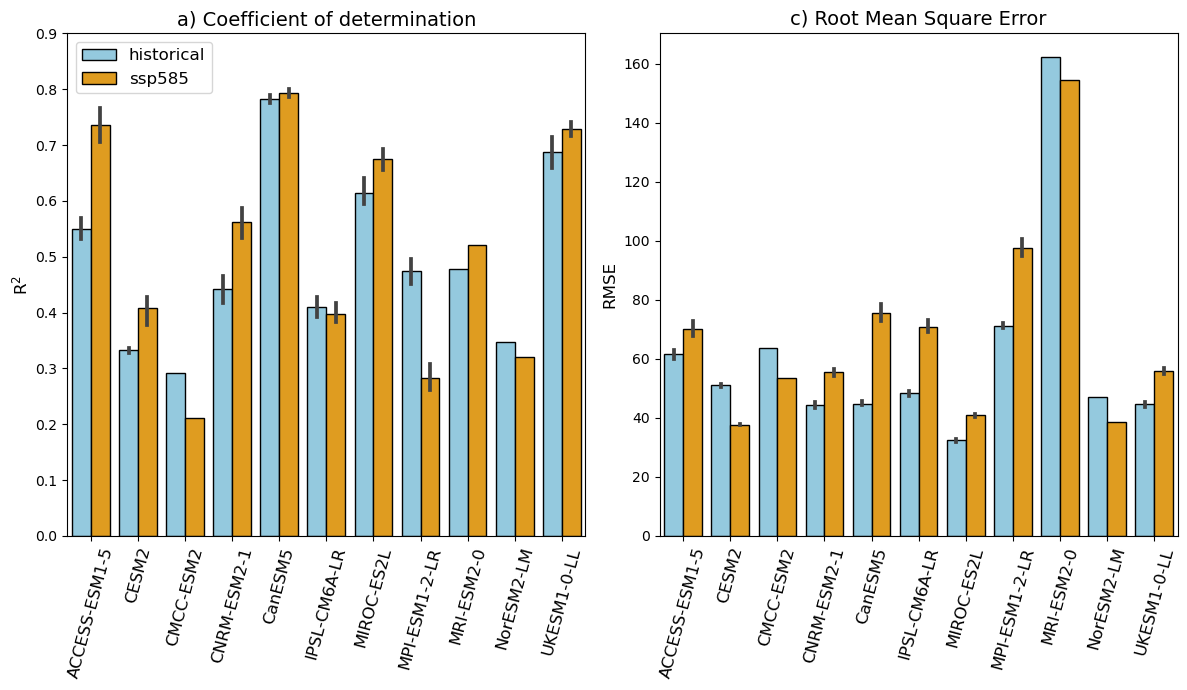

In [22]:
fig = plt.figure(figsize=(12, 7))

legend_labels = {"hist": "historical", "ssp": "ssp585"}

ax0 = fig.add_subplot(121)
data = fit_nbp_test[fit_nbp_test["params"] == "r2"]
ax0 = sns.barplot(
    data=data, hue="scenario",# errorbar=("pi", 50),
    x="esm", y="values",
    palette=["skyblue", "orange"], alpha=1, edgecolor='black', 
)
ax0.set_xticklabels(sorted(list(set(esm_list))), rotation = 75, fontsize=12)
ax0.set_ylim(0, 0.9)
ax0.set_xlabel("")
ax0.set_ylabel("R$^{2}$", fontsize = 12)
ax0.set_title("a) Coefficient of determination", fontsize = 14)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, [legend_labels[label] for label in labels], loc="upper left", fontsize=12)

# ax1 = fig.add_subplot(222)
# data = fit_nbp_test[fit_nbp_test["params"] == "evs"]
# ax1 = sns.barplot(
#     data=data, hue="scenario",# errorbar=("pi", 50),
#     x="esm", y="values",
#     palette=["skyblue", "orange"], alpha=1, edgecolor='black', 
# )
# ax1.set_xticklabels(sorted(list(set(esm_list))), rotation = 75, fontsize=12)
# ax1.set_ylim(0, 0.9)
# ax1.set_xlabel("")
# ax1.set_ylabel("EVS", fontsize = 12)
# ax1.set_title("b) Explained Variance Score", fontsize = 14)
# ax1.get_legend().remove()

ax1 = fig.add_subplot(122)
data = fit_nbp_test[fit_nbp_test["params"] == "rmse"]
ax1 = sns.barplot(
    data=data, hue="scenario",# errorbar=("pi", 50),
    x="esm", y="values",
    palette=["skyblue", "orange"], alpha=1, edgecolor='black', 
)
ax1.set_xticklabels(sorted(list(set(esm_list))), rotation = 75, fontsize=12)
# ax1.set_ylim(0, 1)
ax1.set_xlabel("")
ax1.set_ylabel("RMSE", fontsize = 12)
ax1.set_title("c) Root Mean Square Error", fontsize = 14)
ax1.get_legend().remove()

# ax3 = fig.add_subplot(224)
# data = fit_nbp_test[fit_nbp_test["params"] == "mae"]
# ax3 = sns.barplot(
#     data=data, hue="scenario",# errorbar=("pi", 50),
#     x="esm", y="values",
#     palette=["skyblue", "orange"], alpha=1, edgecolor='black', 
# )
# ax3.set_xticklabels(sorted(list(set(esm_list))), rotation = 75, fontsize=12)
# # ax3.set_ylim(0, 1)
# ax3.set_xlabel("")
# ax3.set_ylabel("MAE", fontsize = 12)
# ax3.set_title("d) Mean Absolute Error", fontsize = 14)
# ax3.get_legend().remove()

fig.tight_layout()
title = "Figure S10"
fig.savefig(os.path.join(out_path, title + ".pdf"), dpi = 400)

#### Optimized model performance

In [ ]:
# Convert to pandas df to compute the model performances statistics 

df_nbp_hist = xr.concat(ds_hist_nbp_amz, dim = "esm").to_dataframe()
df_nbp_hist = df_nbp_hist.reset_index().drop(columns = ["time","region"])
df_pred_hist = xr.concat(pred_nbp_hist_amz, dim = "esm").to_dataframe()
df_pred_hist = df_pred_hist.reset_index().drop(columns = ["time","region"])

df_nbp_ssp = xr.concat(ds_ssp_nbp_amz, dim = "esm").to_dataframe()
df_nbp_ssp = df_nbp_ssp.reset_index().drop(columns = ["time","region"])
df_pred_ssp = xr.concat(pred_nbp_ssp_amz, dim = "esm").to_dataframe()
df_pred_ssp = df_pred_ssp.reset_index().drop(columns = ["time","region"])

In [ ]:
df_nbp_hist["esm"] = df_nbp_hist["esm"].map(dict(zip(df_nbp_hist["esm"].unique(), esm_list)))
df_pred_hist["esm"] = df_pred_hist["esm"].map(dict(zip(df_pred_hist["esm"].unique(), esm_list)))
# df_nbp_hist["scenario"] = "historical"; df_pred_hist["scenario"] = "historical"

df_nbp_ssp["esm"] = df_nbp_ssp["esm"].map(dict(zip(df_nbp_ssp["esm"].unique(), esm_list)))
df_pred_ssp["esm"] = df_pred_ssp["esm"].map(dict(zip(df_pred_ssp["esm"].unique(), esm_list)))
# df_nbp_ssp["scenario"] = "ssp585"; df_pred_ssp["scenario"] = "ssp585"

In [42]:
import seaborn as sns
from scipy import stats
from matplotlib.lines import Line2D
from sklearn import metrics

hist = pd.concat([test_nbp_hist.set_index("esm"),test_pred_hist.set_index("esm")], axis = 1, join="outer")
ssp = pd.concat([test_nbp_ssp.set_index("esm"),test_pred_ssp.set_index("esm")], axis = 1, join="outer")
panels = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) ", "g) ", "h) ", "i) ", "j) ", "k) "]

fig, axs = plt.subplots(3, 4, figsize=(14, 10), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axs = axs.flatten()

for i, mm in enumerate(esm):
    ax = axs[i]
    data = hist[hist.index == mm]
    ax = sns.scatterplot(data["nbp"], data["nbp_pred"], data=data, legend = False, color = "skyblue", ax = ax, label = "historical")#; handle_hist = ax.get_legend_handles_labels()
    sns.regplot(x=data["nbp"], y=data["nbp_pred"], data=data, scatter=False, line_kws={"color": "blue"}, scatter_kws={"color":"blue"}, ax = ax)
    ax.text(.05, .9, 'R$^2$={:.2f}'.format(metrics.r2_score(data["nbp"], data["nbp_pred"])),
                transform=ax.transAxes, color = "blue", fontsize = 10)
    # ax.text(.15, .9, 'p-value={:.4f}'.format(stats.linregress(data["nbp"], data["nbp_pred"]).pvalue),
    #     transform=ax.transAxes, fontsize = 10)
    
    data = ssp[ssp.index == mm]
    ax = sns.scatterplot(data["nbp"], data["nbp_pred"], data=data, legend = False, color = "orange", ax = ax, label = "ssp585")
    sns.regplot(x=data["nbp"], y=data["nbp_pred"], data=data, scatter=False, line_kws={"color": "red"}, scatter_kws={"color":"orange"}, ax = ax)
    ax.text(.05, .85, 'R$^2$={:.2f}'.format(metrics.r2_score(data["nbp"], data["nbp_pred"])),
                transform=ax.transAxes, color = "red", fontsize = 10)
    # ax.text(.15, .85, 'p-value={:.4f}'.format(stats.linregress(data["nbp"], data["nbp_pred"]).pvalue),
    #     transform=ax.transAxes, fontsize = 10)
    ax.set(xlabel="NBP" + ' (gCm$^{-2}$y$^{-1}$)', ylabel="NBP predicted" + ' (gCm$^{-2}$y$^{-1}$)')
    ax.set_title(panels[i] + esm[i])

fig.delaxes(axs.flatten()[-1])
fig.tight_layout()
legend_elements = [Line2D([0], [0], marker='o', color='w', label='historical', markerfacecolor='skyblue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='ssp585', markerfacecolor='orange', markersize=8)]
fig.legend(handles=legend_elements, loc="lower right", fontsize=10, title="Scenario", bbox_to_anchor=(0.9, 0.2))

title = "Figure S11"
output_file = os.path.join(out_path, title) + ".pdf"
plt.savefig(output_file, bbox_inches='tight', dpi = 400)


NameError: name 'test_nbp_hist' is not defined

Text(0.5, 1.02, 'Residuals plot')

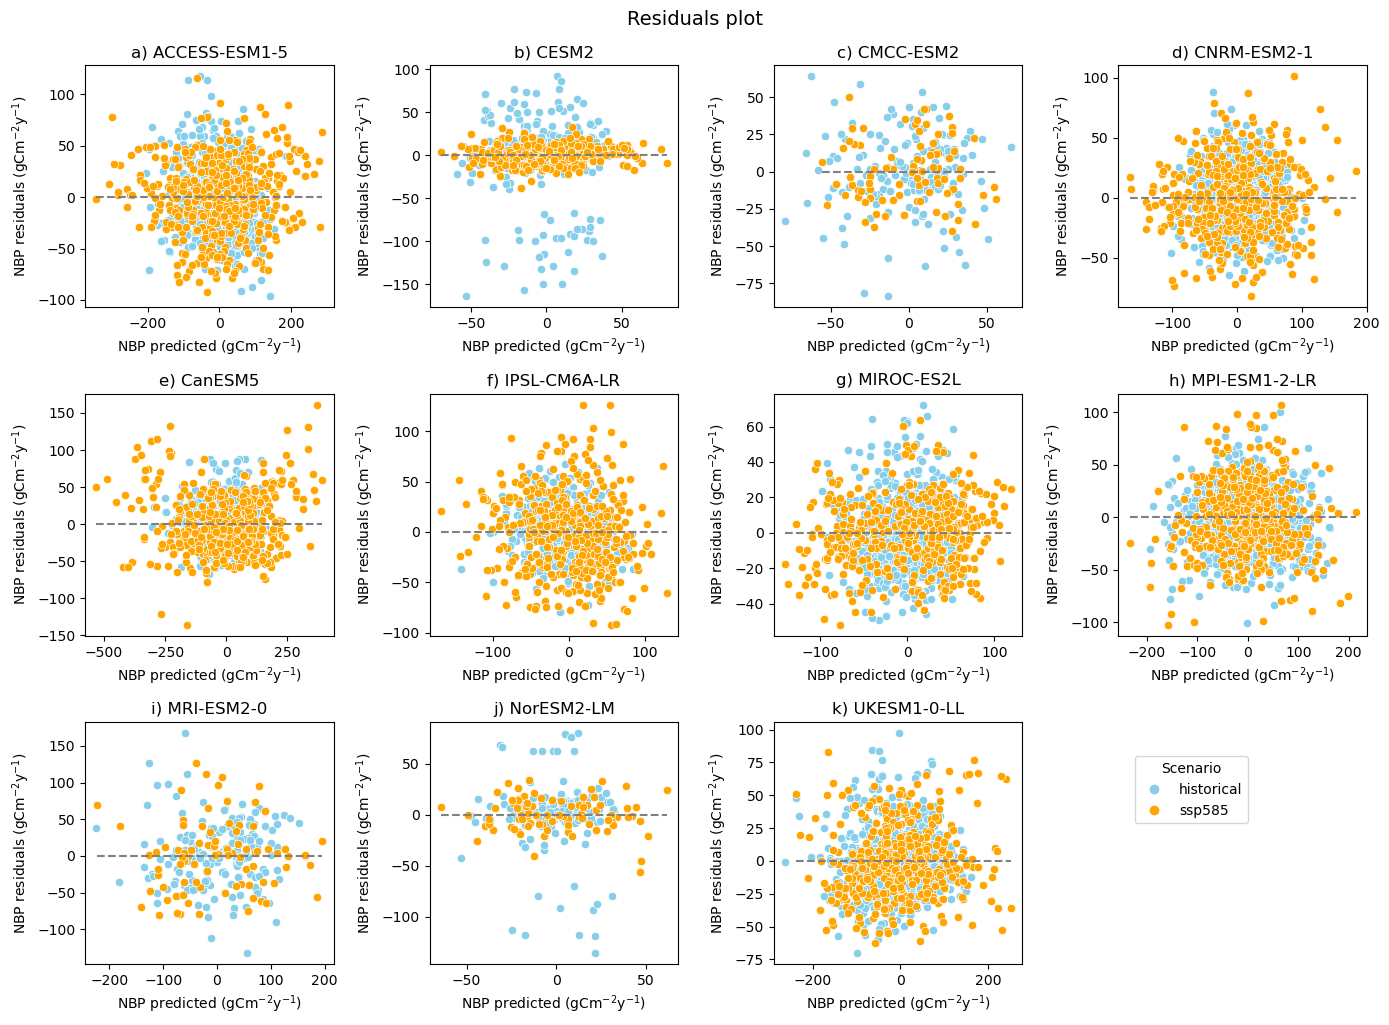

In [142]:
import seaborn as sns
from scipy import stats
from matplotlib.lines import Line2D
panels = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) ", "g) ", "h) ", "i) ", "j) ", "k) "]

hist = pd.concat([test_nbp_hist.set_index("esm"),test_pred_hist.set_index("esm")], axis = 1, join="outer")
ssp = pd.concat([test_nbp_ssp.set_index("esm"),test_pred_ssp.set_index("esm")], axis = 1, join="outer")

fig, axs = plt.subplots(3, 4, figsize=(14, 10), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
axs = axs.flatten()

for i, mm in enumerate(esm):
    ax = axs[i]
    data = hist[hist.index == mm]
    sns.scatterplot(data["nbp_pred"], (data["nbp"] - data["nbp_pred"]), data=data, legend = False, color = "skyblue", ax = ax, label = "historical")#; handle_hist = ax.get_legend_handles_labels()
    
    data = ssp[ssp.index == mm]
    sns.scatterplot(data["nbp_pred"], (data["nbp"] - data["nbp_pred"]), data=data, legend = False, color = "orange", ax = ax, label = "ssp585")

    ax.hlines(0, data["nbp_pred"].min(), data["nbp_pred"].max(), linestyle = "--", color = "grey")

    ax.set(xlabel="NBP predicted" + ' (gCm$^{-2}$y$^{-1}$)', ylabel="NBP residuals" + ' (gCm$^{-2}$y$^{-1}$)')
    ax.set_title(panels[i] + esm[i])

fig.delaxes(axs.flatten()[-1])
fig.tight_layout()
legend_elements = [Line2D([0], [0], marker='o', color='w', label='historical', markerfacecolor='skyblue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='ssp585', markerfacecolor='orange', markersize=8)]
fig.legend(handles=legend_elements, loc="lower right", fontsize=10, title="Scenario", bbox_to_anchor=(0.9, 0.2))
title = "Residuals plot"
fig.suptitle(title, y = 1.02, fontsize = 14)

# output_file = os.path.join(out_path, title) + "_f.png"
# plt.savefig(output_file, bbox_inches='tight')


#### Conversion to pandas dataframe
Cumulative carbon fluxes

In [ ]:
nbp_hist_amz = [a.std(dim = "time") for a in ds_hist_nbp_amz]#; nbp_hist_amz = [a.isel(time = -1) for a in nbp_hist_amz]
nbp_ssp_amz = [a.std(dim = "time") for a in ds_ssp_nbp_amz]#; nbp_ssp_amz = [a.isel(time = -1) for a in nbp_ssp_amz]
pred_cum_nbp_hist_amz = [a.std(dim = "time") for a in pred_nbp_hist_amz]#; pred_cum_nbp_hist_amz = [a.isel(time = -1) for a in pred_cum_nbp_hist_amz]
pred_cum_nbp_ssp_amz = [a.std(dim = "time") for a in pred_nbp_ssp_amz]#; pred_cum_nbp_ssp_amz = [a.isel(time = -1) for a in pred_cum_nbp_ssp_amz]

gpp_hist_amz = [a.std(dim = "time") for a in ds_hist_gpp_amz]#; gpp_hist_amz = [a.isel(time = -1) for a in gpp_hist_amz]
gpp_ssp_amz = [a.std(dim = "time") for a in ds_ssp_gpp_amz]#; gpp_ssp_amz = [a.isel(time = -1) for a in gpp_ssp_amz]
pred_cum_gpp_hist_amz = [a.std(dim = "time") for a in pred_gpp_hist_amz]#; pred_cum_gpp_hist_amz = [a.isel(time = -1) for a in pred_cum_gpp_hist_amz]
pred_cum_gpp_ssp_amz = [a.std(dim = "time") for a in pred_gpp_ssp_amz]#; pred_cum_gpp_ssp_amz = [a.isel(time = -1) for a in pred_cum_gpp_ssp_amz]

ra_hist_amz = [a.std(dim = "time") for a in ds_hist_ra_amz]#; ra_hist_amz = [a.isel(time = -1) for a in ra_hist_amz]
ra_ssp_amz = [a.std(dim = "time") for a in ds_ssp_ra_amz]#; ra_ssp_amz = [a.isel(time = -1) for a in ra_ssp_amz]
pred_cum_ra_hist_amz = [a.std(dim = "time") for a in pred_ra_hist_amz]#; pred_cum_ra_hist_amz = [a.isel(time = -1) for a in pred_cum_ra_hist_amz]
pred_cum_ra_ssp_amz = [a.std(dim = "time") for a in pred_ra_ssp_amz]#; pred_cum_ra_ssp_amz = [a.isel(time = -1) for a in pred_cum_ra_ssp_amz]

rh_hist_amz = [a.std(dim = "time") for a in ds_hist_rh_amz]#; rh_hist_amz = [a.isel(time = -1) for a in rh_hist_amz]
rh_ssp_amz = [a.std(dim = "time") for a in ds_ssp_rh_amz]#; rh_ssp_amz = [a.isel(time = -1) for a in rh_ssp_amz]
pred_cum_rh_hist_amz = [a.std(dim = "time") for a in pred_rh_hist_amz]#; pred_cum_rh_hist_amz = [a.isel(time = -1) for a in pred_cum_rh_hist_amz]
pred_cum_rh_ssp_amz = [a.std(dim = "time") for a in pred_rh_ssp_amz]#; pred_cum_rh_ssp_amz = [a.isel(time = -1) for a in pred_cum_rh_ssp_amz]

Covert xarray to pandas DF

In [108]:
# List of variable names corresponding to the coefficients
xr_list = [coef_nbp_hist_amz] #, coef_ra_hist_amz, coef_rh_hist_amz, coef_gpp_hist_amz]#, ]
cum_list = [nbp_hist_amz] #, ra_hist_amz, rh_hist_amz, gpp_hist_amz]#, ]
pred_list = [pred_cum_nbp_hist_amz] #, pred_cum_ra_hist_amz, pred_cum_rh_hist_amz, pred_cum_gpp_hist_amz]#, ]
fit_list = [fit_nbp_hist_amz] #, fit_ra_hist_amz, fit_rh_hist_amz, fit_gpp_hist_amz]

carbon_vars = ["nbp"]#, "ra", "rh", "gpp"]#]
variables = ["tas", "mrso", "rsds"]#, "vpd", "enso"]
fit_vars = ["r2", "rmse", "mae", "evs", "evs_tas", "evs_mrso", "evs_rsds", "pval_tas", "pval_mrso", "pval_rsds"]

# Extract and convert coefficients to DataFrames

dfs = []
for x, cvar in enumerate(carbon_vars):
    for i, var in enumerate(variables):
        df = (
            xr.concat([a.sel(coefficients=i).rename(carbon_vars[x] + "_" + var) for a in xr_list[x]], dim="esm")
            .to_dataframe()
            .drop(columns="region")
        )
        df = df.rename(index=dict(zip(df.index, esm_list)))  # Use df from the current iteration
        dfs.append(df)

        dfstd = (
            xr.concat([(a.sel(coefficients=i) / b).rename(carbon_vars[x] + "_" + var + "_std") for a, b in zip(xr_list[x], cum_list[x])], dim="esm")
            .to_dataframe()
            .drop(columns="region")
        )
        dfstd = dfstd.rename(index=dict(zip(dfstd.index, esm_list)))  # Use df from the current iteration
        dfs.append(dfstd)       

    for i, item in enumerate(fit_vars):
        dfa = (
            xr.concat([a.sel(params=i).rename(carbon_vars[x] + "_" + item) for a in fit_list[x]], dim="esm")
            .to_dataframe()
            .drop(columns="region")
        )
        dfa = dfa.rename(index=dict(zip(dfa.index, esm_list)))  # Use df from the current iteration
        dfs.append(dfa)

    df1 = (
        xr.concat([a.rename(carbon_vars[x] + "_std")  for a in cum_list[x]], dim="esm")
        .to_dataframe()
        .drop(columns=["region"])
    )
    df1 = df1.rename(index=dict(zip(df1.index, esm_list))) 
    dfs.append(df1)

    df2 = (
        xr.concat([a.rename(carbon_vars[x] + "_std_pred")  for a in pred_list[x]], dim="esm")
        .to_dataframe()
        .drop(columns=["region"])
    )
    df2 = df2.rename(index=dict(zip(df2.index, esm_list)))
    dfs.append(df2)

# Combine all DataFrames into one
df_amz_hist = pd.concat(dfs, axis = 1)

In [107]:
# List of variable names corresponding to the coefficients
xr_list = [coef_nbp_ssp_amz]#,coef_ra_ssp_amz, coef_rh_ssp_amz, coef_gpp_ssp_amz]#, ]
cum_list = [nbp_ssp_amz]#, ra_ssp_amz, rh_ssp_amz, gpp_ssp_amz]#]
pred_list = [pred_cum_nbp_ssp_amz]#, pred_cum_ra_ssp_amz, pred_cum_rh_ssp_amz, pred_cum_gpp_ssp_amz]#]
fit_list = [fit_nbp_ssp_amz] #, fit_ra_hist_amz, fit_rh_hist_amz, fit_gpp_hist_amz]

carbon_vars = ["nbp"] #, "ra", "rh", "gpp"]#]
variables = ["tas", "mrso", "rsds"]#, "vpd", "enso"]
fit_vars = ["r2", "rmse", "mae", "evs", "evs_tas", "evs_mrso", "evs_rsds", "pval_tas", "pval_mrso", "pval_rsds"]

# Extract and convert coefficients to DataFrames
dfs = []
for x, cvar in enumerate(carbon_vars):
    for i, var in enumerate(variables):
        df = (
            xr.concat([a.sel(coefficients=i).rename(carbon_vars[x] + "_" + var) for a in xr_list[x]], dim="esm")
            .to_dataframe()
            .drop(columns="region")
        )
        df = df.rename(index=dict(zip(df.index, esm_list)))  # Use df from the current iteration
        dfs.append(df)

        dfstd = (
            xr.concat([(a.sel(coefficients=i) / b).rename(carbon_vars[x] + "_" + var + "_std") for a, b in zip(xr_list[x], cum_list[x])], dim="esm")
            .to_dataframe()
            .drop(columns="region")
        )
        dfstd = dfstd.rename(index=dict(zip(dfstd.index, esm_list)))  # Use df from the current iteration
        dfs.append(dfstd)       

    for i, item in enumerate(fit_vars):
        dfa = (
            xr.concat([a.sel(params=i).rename(carbon_vars[x] + "_" + item) for a in fit_list[x]], dim="esm")
            .to_dataframe()
            .drop(columns="region")
        )
        dfa = dfa.rename(index=dict(zip(dfa.index, esm_list)))  # Use df from the current iteration
        dfs.append(dfa)
    
    df1 = (
        xr.concat([a.rename(carbon_vars[x] + "_std")  for a in cum_list[x]], dim="esm")
        .to_dataframe()
        .drop(columns=["region"])
    )
    df1 = df1.rename(index=dict(zip(df1.index, esm_list))) 
    dfs.append(df1)

    df2 = (
        xr.concat([a.rename(carbon_vars[x] + "_std_pred")  for a in pred_list[x]], dim="esm")
        .to_dataframe()
        .drop(columns=["region"])
    )
    df2 = df2.rename(index=dict(zip(df2.index, esm_list))) 
    dfs.append(df2)
# Combine all DataFrames into one
df_amz_ssp = pd.concat(dfs, axis = 1)

#### Barplots of coefficients

In [109]:
df_amz_hist["esm"] = df_amz_hist.index
df_amz_hist_long = pd.melt(df_amz_hist,id_vars="esm", var_name="effect"); df_amz_hist_long["scenario"] = "hist"
df_amz_ssp["esm"] = df_amz_ssp.index
df_amz_ssp_long = pd.melt(df_amz_ssp,id_vars="esm", var_name="effect"); df_amz_ssp_long["scenario"] = "ssp"

df = pd.concat([df_amz_hist_long, df_amz_ssp_long], axis = 0)

df_delta = (df_amz_ssp.drop(columns=["esm"]) - df_amz_hist.drop(columns=["esm"])); df_delta["esm"] = df_delta.index
df_delta = pd.melt(df_delta, id_vars="esm", var_name="effect")


Increased NBP interannual variability in ssp585 vs historical explains the increased coefficients in ssp585 vs historical 

In [37]:
df.to_csv(os.path.join(out_path,"df_coeff_mlr_final.csv"))
df = pd.read_csv(os.path.join(out_path,"df_coeff_mlr_final.csv"))
import seaborn as sns

Plot Explained Variance Score

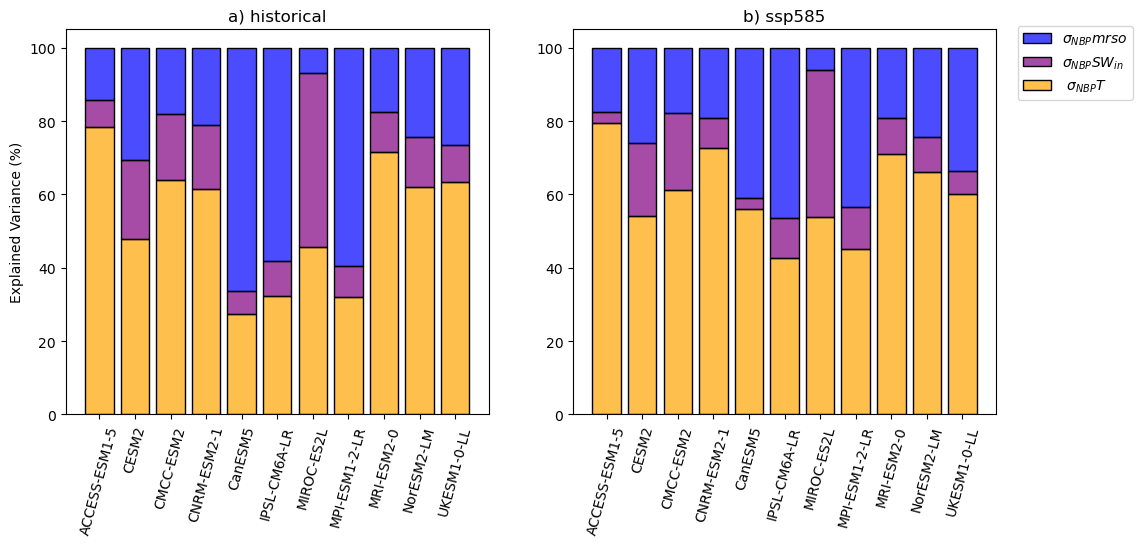

In [122]:
fig = plt.figure(figsize=(12, 5))

data = df[(df['effect'] == 'nbp_evs_tas') | (df['effect'] == 'nbp_evs_mrso') | (df['effect'] == 'nbp_evs_rsds')].copy()# | (df['effect'] == 'nbp_vpd')].copy()
data = data[data['scenario'] == 'hist']
data = data.groupby(["esm", "effect"]).mean().reset_index()
custom_palette = {
    "nbp_evs_tas": "orange", 
    "nbp_evs_mrso": "blue", 
    "nbp_evs_rsds": "purple"
}

# Plot stacked barplot using hue
ax0 = fig.add_subplot(121)
ax0 = sns.histplot(
    data=data, 
    x="esm", 
    weights="value",  # Ensures correct contribution per category
    hue="effect",  
    multiple="stack",  # Ensures bars are stacked instead of overlaid
    discrete=True,  # Treats 'esm' as categorical
    shrink=0.8,  # Adjusts bar width for better visibility
    alpha = 0.7,
    edgecolor="black",
    palette = custom_palette
)

ax0.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax0.set_xlabel("")
ax0.set_ylabel("Explained Variance (%)")
ax0.set_title("a) historical")
ax0.get_legend().remove()

data = df[(df['effect'] == 'nbp_evs_tas') | (df['effect'] == 'nbp_evs_mrso') | (df['effect'] == 'nbp_evs_rsds')].copy()# | (df['effect'] == 'nbp_vpd')].copy()
data = data[data['scenario'] == 'ssp']
data = data.groupby(["esm", "effect"]).mean().reset_index()

ax1 = fig.add_subplot(122)
ax1 = sns.histplot(
    data=data, 
    x="esm", 
    weights="value",  # Ensures correct contribution per category
    hue="effect",  
    multiple="stack",  # Ensures bars are stacked instead of overlaid
    discrete=True,  # Treats 'esm' as categorical
    shrink=0.8,  # Adjusts bar width for better visibility
    alpha = 0.7,
    edgecolor="black",
    palette = custom_palette
)

ax1.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title("b) ssp585")

handles, labels = ax1.get_legend().legendHandles, ax1.get_legend().texts
legend_labels = {
    "nbp_evs_tas": " $\sigma_{NBP}T$",
    "nbp_evs_mrso": "$\sigma_{NBP}mrso$",
    "nbp_evs_rsds": "$\sigma_{NBP}SW_{in}$"
}
new_labels = [legend_labels[label.get_text()] for label in labels]
ax1.get_legend().remove()

fig.legend(handles=handles, labels=new_labels, loc="upper right", fontsize=10, title="", bbox_to_anchor=(1.02, 0.9))

In [ ]:
ax1 = fig.add_subplot(122)

ax1 = sns.histplot(
    data=data, 
    x="esm", 
    weights="value",  # Ensures correct contribution per category
    hue="effect",  
    multiple="stack",  # Ensures bars are stacked instead of overlaid
    discrete=True,  # Treats 'esm' as categorical
    shrink=0.8,  # Adjusts bar width for better visibility
    alpha = 0.7,
    edgecolor="black",
    palette = custom_palette
)

ax1.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax1.set_xlabel("")
ax1.set_ylabel("Explained Variance (%)")
ax1.set_title("$\sigma_{NBP}$")

handles, labels = ax1.get_legend().legendHandles, ax1.get_legend().texts
legend_labels = {
    "nbp_evs_tas": " $\sigma_{NBP}T$",
    "nbp_evs_mrso": "$\sigma_{NBP}mrso$",
    "nbp_evs_rsds": "$\sigma_{NBP}SW_{in}$"
}
new_labels = [legend_labels[label.get_text()] for label in labels]
ax1.get_legend().remove()

fig.legend(handles=handles, labels=new_labels, loc="upper right", fontsize=10, title="", bbox_to_anchor=(1.12, 0.9))

Plot Regression Coefficients

ACCESS-ESM1-5 first NBP predictor: Temperature
CESM2 first NBP predictor: Temperature
CMCC-ESM2 first NBP predictor: Temperature
CNRM-ESM2-1 first NBP predictor: Temperature
CanESM5 first NBP predictor: Temperature
IPSL-CM6A-LR first NBP predictor: Soil Moisture
MIROC-ES2L first NBP predictor: Temperature
MPI-ESM1-2-LR first NBP predictor: Soil Moisture
MRI-ESM2-0 first NBP predictor: Temperature
NorESM2-LM first NBP predictor: Temperature
UKESM1-0-LL first NBP predictor: Temperature


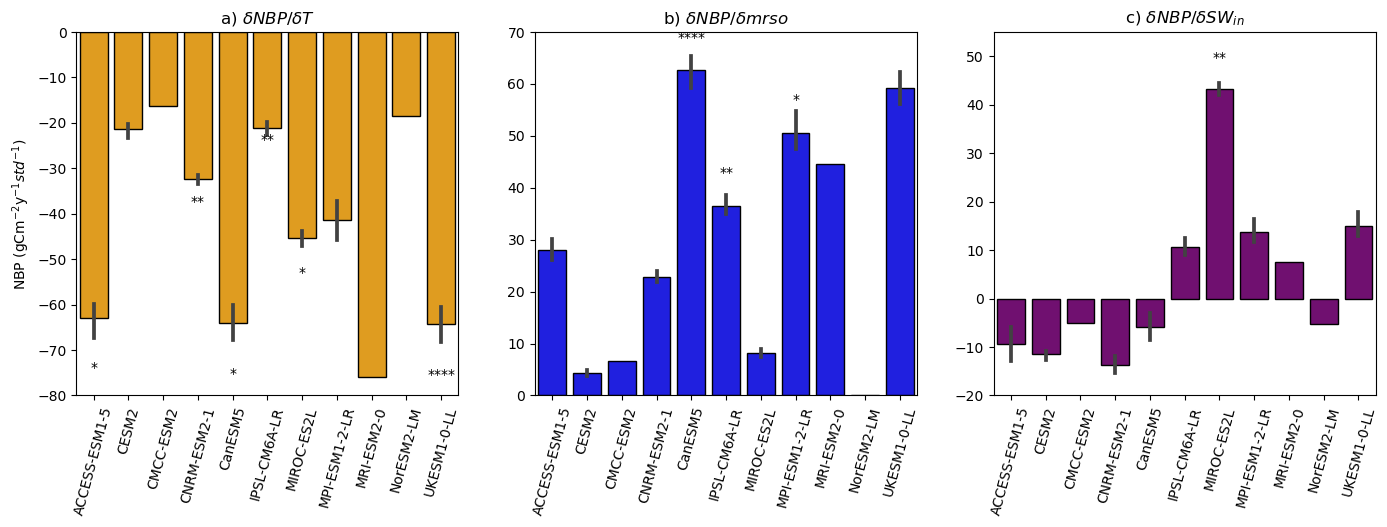

In [43]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 3)

data = df[(df['effect'] == 'nbp_tas') | (df['effect'] == 'nbp_mrso') | (df['effect'] == 'nbp_rsds') | 
          (df['effect'] == 'nbp_pval_tas') | (df['effect'] == 'nbp_pval_mrso') | (df['effect'] == 'nbp_pval_rsds')].copy()# | (df['effect'] == 'nbp_vpd')].copy()
data = data[data['scenario'] == 'ssp']

pval = data[data["effect"] == "nbp_pval_tas"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(gs[0, 0])
ax0 = sns.barplot(
    data=data[data["effect"] == "nbp_tas"].rename(columns={'effect': 'variable'}), # hue="variable",# errorbar=("pi", 50),
    x="esm", y="value",
    color='orange', alpha=1, edgecolor='black' , 
)
y_position = data[data["effect"] == "nbp_tas"].groupby("esm").mean()["value"] * 1.2# 5
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax0.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

ax0.set_ylim(-80, 0)
ax0.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax0.set_xlabel("")
ax0.set_ylabel("NBP (gCm$^{-2}$y$^{-1}std^{-1}$)")
ax0.set_title("a) $\delta NBP/\delta T$")


pval = data[data["effect"] == "nbp_pval_mrso"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

ax1 = fig.add_subplot(gs[0, 1])
ax1 = sns.barplot(
    data=data[data["effect"] == "nbp_mrso"].rename(columns={'effect': 'variable'}), # hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    color='blue', alpha=1, edgecolor='black' 
)
y_position = data[data["effect"] == "nbp_mrso"].groupby("esm").mean()["value"] + 5
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax1.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

ax1.set_ylim(0, 70)
ax1.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("b) $\delta NBP/\delta mrso$")


pval = data[data["effect"] == "nbp_pval_rsds"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

ax2 = fig.add_subplot(gs[0, 2])
ax2 = sns.barplot(
    data=data[data["effect"] == "nbp_rsds"].rename(columns={'effect': 'variable'}), # hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    color='purple', alpha=1, edgecolor='black' 
)
ax2.set_ylim(-20, 55)
y_position = data[data["effect"] == "nbp_rsds"].groupby("esm").mean()["value"] + 5
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax2.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

ax2.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_title("c) $\delta NBP/\delta SW_{in}$")

fig.tight_layout()
fig.subplots_adjust(
    top=1,  # Leave space for suptitle
    hspace=0.4,  # Vertical space between rows
    wspace=0.2   # Horizontal space between columns
)

title = 'Predictors coefficients in the Amazon Basin - NBP ssp'
# fig.suptitle(title, y = 1.05, fontsize = 14)
output_file = os.path.join(out_path, title) + ".png"

# plt.savefig(output_file, bbox_inches='tight')

test = pd.DataFrame(
    data[data["effect"] == "nbp_tas"].groupby("esm").mean()["value"].abs() - 
    data[data["effect"] == "nbp_mrso"].groupby("esm").mean()["value"].abs()
).reset_index()
test.columns = ["esm", "value"]  # Rename columns for clarity

for i, model in enumerate(esm):
    value = test.loc[test["esm"] == model, "value"].values[0]  # Extract the scalar value
    if value > 0:
        print(f"{model} first NBP predictor: Temperature")
    else:
        print(f"{model} first NBP predictor: Soil Moisture")


ACCESS-ESM1-5 first GPP predictor: gpp_tas
CESM2 first GPP predictor: gpp_mrso
CMCC-ESM2 first GPP predictor: gpp_rsds
CNRM-ESM2-1 first GPP predictor: gpp_tas
CanESM5 first GPP predictor: gpp_mrso
IPSL-CM6A-LR first GPP predictor: gpp_mrso
MIROC-ES2L first GPP predictor: gpp_rsds
MPI-ESM1-2-LR first GPP predictor: gpp_mrso
MRI-ESM2-0 first GPP predictor: gpp_mrso
NorESM2-LM first GPP predictor: gpp_mrso
UKESM1-0-LL first GPP predictor: gpp_mrso


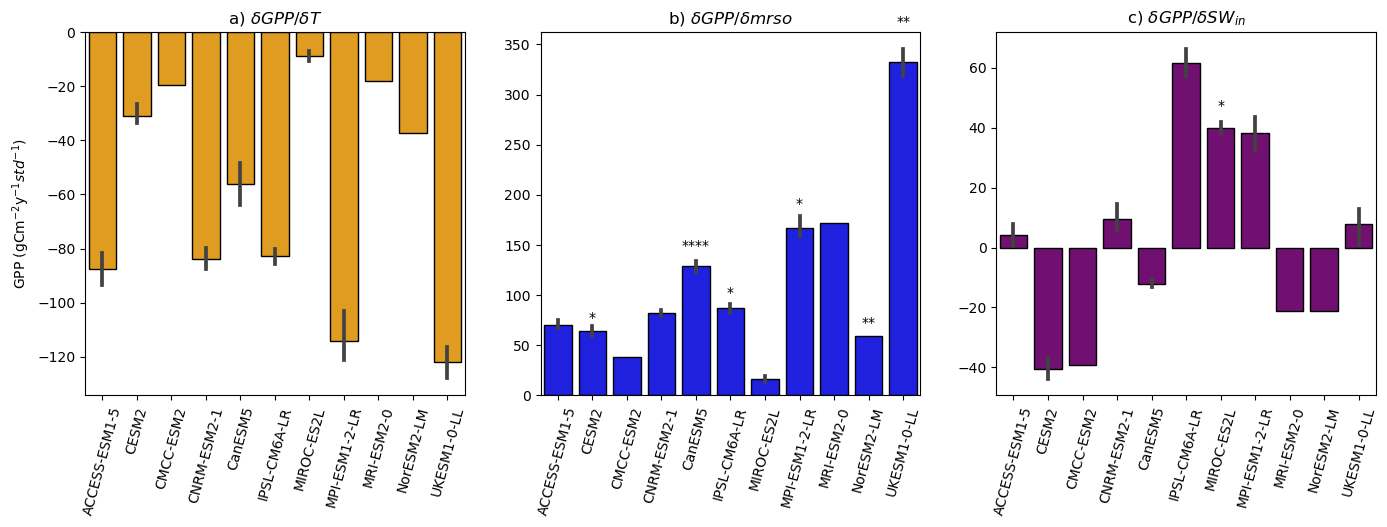

In [44]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 3)

data = df[(df['effect'] == 'gpp_tas') | (df['effect'] == 'gpp_mrso') | (df['effect'] == 'gpp_rsds') | 
          (df['effect'] == 'gpp_pval_tas') | (df['effect'] == 'gpp_pval_mrso') | (df['effect'] == 'gpp_pval_rsds')].copy()# | (df['effect'] == 'gpp_vpd')].copy()
data = data[data['scenario'] == 'ssp']

pval = data[data["effect"] == "gpp_pval_tas"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(gs[0, 0])
ax0 = sns.barplot(
    data=data[data["effect"] == "gpp_tas"].rename(columns={'effect': 'variable'}), # hue="variable",# errorbar=("pi", 50),
    x="esm", y="value",
    color='orange', alpha=1, edgecolor='black' , 
)
y_position = data[data["effect"] == "gpp_tas"].groupby("esm").mean()["value"] - 15
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax0.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

# ax0.set_ylim(-80, 0)
ax0.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax0.set_xlabel("")
ax0.set_ylabel("GPP (gCm$^{-2}$y$^{-1}std^{-1}$)")
ax0.set_title("a) $\delta GPP/\delta T$")


pval = data[data["effect"] == "gpp_pval_mrso"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

ax1 = fig.add_subplot(gs[0, 1])
ax1 = sns.barplot(
    data=data[data["effect"] == "gpp_mrso"].rename(columns={'effect': 'variable'}), # hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    color='blue', alpha=1, edgecolor='black' 
)
y_position = data[data["effect"] == "gpp_mrso"].groupby("esm").mean()["value"] * 1.1 
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax1.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

# ax1.set_ylim(0, 70)
ax1.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("b) $\delta GPP/\delta mrso$")


pval = data[data["effect"] == "gpp_pval_rsds"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

ax2 = fig.add_subplot(gs[0, 2])
ax2 = sns.barplot(
    data=data[data["effect"] == "gpp_rsds"].rename(columns={'effect': 'variable'}), # hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    color='purple', alpha=1, edgecolor='black' 
)
# ax2.set_ylim(-20, 55)
y_position = data[data["effect"] == "gpp_rsds"].groupby("esm").mean()["value"] + 5
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax2.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

ax2.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_title("c) $\delta GPP/\delta SW_{in}$")

fig.tight_layout()
fig.subplots_adjust(
    top=1,  # Leave space for suptitle
    hspace=0.4,  # Vertical space between rows
    wspace=0.2   # Horizontal space between columns
)

title = 'Predictors coefficients in the Amazon Basin - GPP ssp'
# fig.suptitle(title, y = 1.05, fontsize = 14)
output_file = os.path.join(out_path, title) + ".png"

# plt.savefig(output_file, bbox_inches='tight')

# Create a DataFrame with absolute mean values for each predictor
test = pd.DataFrame({
    "esm": data[data["effect"] == "gpp_tas"].groupby("esm").mean()["value"].index,
    "gpp_tas": data[data["effect"] == "gpp_tas"].groupby("esm").mean()["value"].abs().values,
    "gpp_mrso": data[data["effect"] == "gpp_mrso"].groupby("esm").mean()["value"].abs().values,
    "gpp_rsds": data[data["effect"] == "gpp_rsds"].groupby("esm").mean()["value"].abs().values,
}).reset_index(drop=True)

# Ensure columns are numeric
test[["gpp_tas", "gpp_mrso", "gpp_rsds"]] = test[["gpp_tas", "gpp_mrso", "gpp_rsds"]].apply(pd.to_numeric)

# Identify the highest predictor for each ESM
for i, model in enumerate(test["esm"]):
    # Extract the predictor values for the current ESM
    predictors = test.loc[i, ["gpp_tas", "gpp_mrso", "gpp_rsds"]]

    # Convert predictors to numeric if needed
    predictors = predictors.astype(float)

    # Find the column name with the maximum value
    max_predictor = predictors.idxmax()  
    print(f"{model} first GPP predictor: {max_predictor}")



ACCESS-ESM1-5 first Ra predictor: ra_mrso
CESM2 first Ra predictor: ra_tas
CMCC-ESM2 first Ra predictor: ra_mrso
CNRM-ESM2-1 first Ra predictor: ra_mrso
CanESM5 first Ra predictor: ra_mrso
IPSL-CM6A-LR first Ra predictor: ra_tas
MIROC-ES2L first Ra predictor: ra_rsds
MPI-ESM1-2-LR first Ra predictor: ra_mrso
MRI-ESM2-0 first Ra predictor: ra_mrso
NorESM2-LM first Ra predictor: ra_tas
UKESM1-0-LL first Ra predictor: ra_mrso


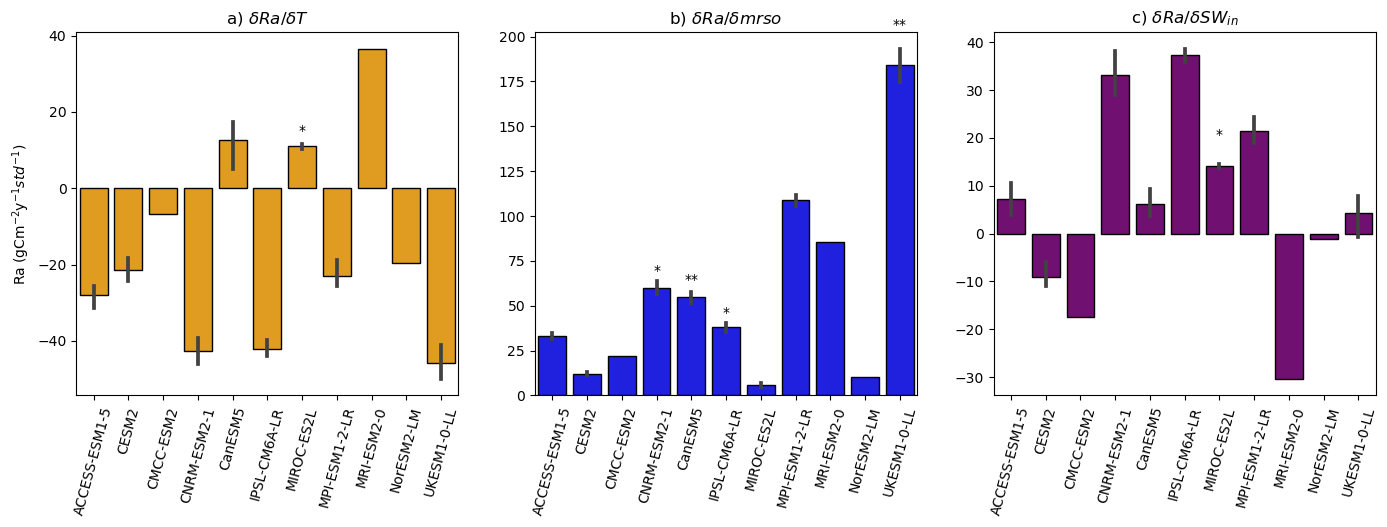

In [45]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 3)

data = df[(df['effect'] == 'ra_tas') | (df['effect'] == 'ra_mrso') | (df['effect'] == 'ra_rsds') | 
          (df['effect'] == 'ra_pval_tas') | (df['effect'] == 'ra_pval_mrso') | (df['effect'] == 'ra_pval_rsds')].copy()# | (df['effect'] == 'ra_vpd')].copy()
data = data[data['scenario'] == 'ssp']

pval = data[data["effect"] == "ra_pval_tas"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(gs[0, 0])
ax0 = sns.barplot(
    data=data[data["effect"] == "ra_tas"].rename(columns={'effect': 'variable'}), # hue="variable",# errorbar=("pi", 50),
    x="esm", y="value",
    color='orange', alpha=1, edgecolor='black' , 
)
y_position = data[data["effect"] == "ra_tas"].groupby("esm").mean()["value"] * 1.2
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax0.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

# ax0.set_ylim(-80, 0)
ax0.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax0.set_xlabel("")
ax0.set_ylabel("Ra (gCm$^{-2}$y$^{-1}std^{-1}$)")
ax0.set_title("a) $\delta Ra/\delta T$")


pval = data[data["effect"] == "ra_pval_mrso"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

ax1 = fig.add_subplot(gs[0, 1])
ax1 = sns.barplot(
    data=data[data["effect"] == "ra_mrso"].rename(columns={'effect': 'variable'}), # hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    color='blue', alpha=1, edgecolor='black' 
)
y_position = data[data["effect"] == "ra_mrso"].groupby("esm").mean()["value"] * 1.1 
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax1.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

# ax1.set_ylim(0, 70)
ax1.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("b) $\delta Ra/\delta mrso$")


pval = data[data["effect"] == "ra_pval_rsds"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

ax2 = fig.add_subplot(gs[0, 2])
ax2 = sns.barplot(
    data=data[data["effect"] == "ra_rsds"].rename(columns={'effect': 'variable'}), # hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    color='purple', alpha=1, edgecolor='black' 
)
# ax2.set_ylim(-20, 55)
y_position = data[data["effect"] == "ra_rsds"].groupby("esm").mean()["value"] + 5
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax2.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

ax2.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_title("c) $\delta Ra/\delta SW_{in}$")

fig.tight_layout()
fig.subplots_adjust(
    top=1,  # Leave space for suptitle
    hspace=0.4,  # Vertical space between rows
    wspace=0.2   # Horizontal space between columns
)

title = 'Predictors coefficients in the Amazon Basin - Ra ssp'
# fig.suptitle(title, y = 1.05, fontsize = 14)
output_file = os.path.join(out_path, title) + ".png"

# plt.savefig(output_file, bbox_inches='tight')

test = pd.DataFrame({
    "esm": data[data["effect"] == "ra_tas"].groupby("esm").mean()["value"].index,
    "ra_tas": data[data["effect"] == "ra_tas"].groupby("esm").mean()["value"].abs().values,
    "ra_mrso": data[data["effect"] == "ra_mrso"].groupby("esm").mean()["value"].abs().values,
    "ra_rsds": data[data["effect"] == "ra_rsds"].groupby("esm").mean()["value"].abs().values,
}).reset_index(drop=True)

# Ensure columns are numeric
test[["ra_tas", "ra_mrso", "ra_rsds"]] = test[["ra_tas", "ra_mrso", "ra_rsds"]].apply(pd.to_numeric)

# Identify the highest predictor for each ESM
for i, model in enumerate(test["esm"]):
    # Extract the predictor values for the current ESM
    predictors = test.loc[i, ["ra_tas", "ra_mrso", "ra_rsds"]]

    # Convert predictors to numeric if needed
    predictors = predictors.astype(float)

    # Find the column name with the maximum value
    max_predictor = predictors.idxmax()  
    print(f"{model} first Ra predictor: {max_predictor}")

ACCESS-ESM1-5 first Rh predictor: rh_mrso
CESM2 first Rh predictor: rh_mrso
CMCC-ESM2 first Rh predictor: rh_rsds
CNRM-ESM2-1 first Rh predictor: rh_rsds
CanESM5 first Rh predictor: rh_mrso
IPSL-CM6A-LR first Rh predictor: rh_tas
MIROC-ES2L first Rh predictor: rh_tas
MPI-ESM1-2-LR first Rh predictor: rh_tas
MRI-ESM2-0 first Rh predictor: rh_mrso
NorESM2-LM first Rh predictor: rh_mrso
UKESM1-0-LL first Rh predictor: rh_mrso


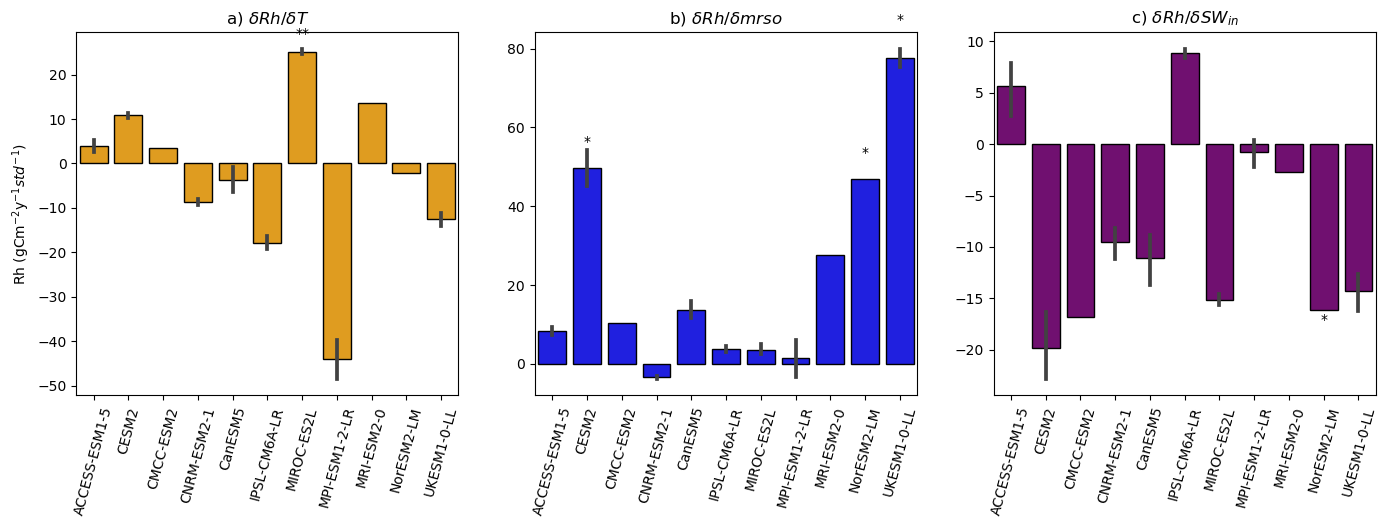

In [46]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 3)

data = df[(df['effect'] == 'rh_tas') | (df['effect'] == 'rh_mrso') | (df['effect'] == 'rh_rsds') | 
          (df['effect'] == 'rh_pval_tas') | (df['effect'] == 'rh_pval_mrso') | (df['effect'] == 'rh_pval_rsds')].copy()# | (df['effect'] == 'rh_vpd')].copy()
data = data[data['scenario'] == 'ssp']

pval = data[data["effect"] == "rh_pval_tas"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(gs[0, 0])
ax0 = sns.barplot(
    data=data[data["effect"] == "rh_tas"].rename(columns={'effect': 'variable'}), # hue="variable",# errorbar=("pi", 50),
    x="esm", y="value",
    color='orange', alpha=1, edgecolor='black' , 
)
y_position = data[data["effect"] == "rh_tas"].groupby("esm").mean()["value"] * 1.1
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax0.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

# ax0.set_ylim(-80, 0)
ax0.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax0.set_xlabel("")
ax0.set_ylabel("Rh (gCm$^{-2}$y$^{-1}std^{-1}$)")
ax0.set_title("a) $\delta Rh/\delta T$")


pval = data[data["effect"] == "rh_pval_mrso"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

ax1 = fig.add_subplot(gs[0, 1])
ax1 = sns.barplot(
    data=data[data["effect"] == "rh_mrso"].rename(columns={'effect': 'variable'}), # hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    color='blue', alpha=1, edgecolor='black' 
)
y_position = data[data["effect"] == "rh_mrso"].groupby("esm").mean()["value"] * 1.1 
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax1.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

# ax1.set_ylim(0, 70)
ax1.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("b) $\delta Rh/\delta mrso$")


pval = data[data["effect"] == "rh_pval_rsds"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

ax2 = fig.add_subplot(gs[0, 2])
ax2 = sns.barplot(
    data=data[data["effect"] == "rh_rsds"].rename(columns={'effect': 'variable'}), # hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    color='purple', alpha=1, edgecolor='black' 
)
# ax2.set_ylim(-20, 55)
y_position = data[data["effect"] == "rh_rsds"].groupby("esm").mean()["value"] * 1.1
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax2.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

ax2.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_title("c) $\delta Rh/\delta SW_{in}$")

fig.tight_layout()
fig.subplots_adjust(
    top=1,  # Leave space for suptitle
    hspace=0.4,  # Vertical space between rows
    wspace=0.2   # Horizontal space between columns
)

title = 'Predictors coefficients in the Amazon Basin - Rh ssp'
# fig.suptitle(title, y = 1.05, fontsize = 14)
output_file = os.path.join(out_path, title) + ".png"

# plt.savefig(output_file, bbox_inches='tight')

test = pd.DataFrame({
    "esm": data[data["effect"] == "rh_tas"].groupby("esm").mean()["value"].index,
    "rh_tas": data[data["effect"] == "rh_tas"].groupby("esm").mean()["value"].abs().values,
    "rh_mrso": data[data["effect"] == "rh_mrso"].groupby("esm").mean()["value"].abs().values,
    "rh_rsds": data[data["effect"] == "rh_rsds"].groupby("esm").mean()["value"].abs().values,
}).reset_index(drop=True)

# Ensure columns are numeric
test[["rh_tas", "rh_mrso", "rh_rsds"]] = test[["rh_tas", "rh_mrso", "rh_rsds"]].apply(pd.to_numeric)

# Identify the highest predictor for each ESM
for i, model in enumerate(test["esm"]):
    # Extract the predictor values for the current ESM
    predictors = test.loc[i, ["rh_tas", "rh_mrso", "rh_rsds"]]

    # Convert predictors to numeric if needed
    predictors = predictors.astype(float)

    # Find the column name with the maximum value
    max_predictor = predictors.idxmax()  
    print(f"{model} first Rh predictor: {max_predictor}")

#### Standardized coefficients

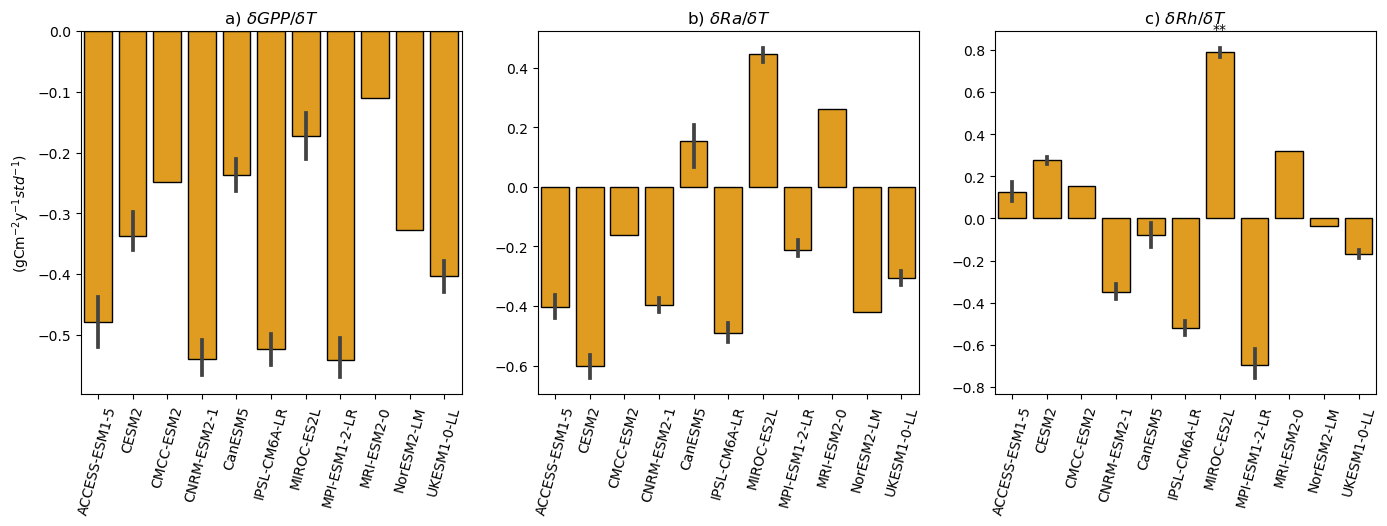

In [98]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 3)

data = df[(df['effect'] == 'gpp_tas') | (df['effect'] == 'ra_tas') | (df['effect'] == 'rh_tas') | 
          (df['effect'] == 'gpp_pval_tas') | (df['effect'] == 'ra_pval_tas') | (df['effect'] == 'rh_pval_tas') |
          (df['effect'] == 'gpp_tas_std') | (df['effect'] == 'ra_tas_std') | (df['effect'] == 'rh_tas_std')].copy()# | (df['effect'] == 'rh_vpd')].copy()
data = data[data['scenario'] == 'ssp']

pval = data[data["effect"] == "gpp_pval_tas"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(gs[0, 0])
ax0 = sns.barplot(
    data=data[data["effect"] == "gpp_tas_std"].rename(columns={'effect': 'variable'}), # hue="variable",# errorbar=("pi", 50),
    x="esm", y="value",
    color='orange', alpha=1, edgecolor='black' , 
)
y_position = data[data["effect"] == "gpp_tas_std"].groupby("esm").mean()["value"] * 1.1
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax0.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

# ax0.set_ylim(-80, 0)
ax0.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax0.set_xlabel("")
ax0.set_ylabel("(gCm$^{-2}$y$^{-1}std^{-1}$)")
ax0.set_title("a) $\delta GPP/\delta T$")


pval = data[data["effect"] == "ra_pval_tas"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

ax1 = fig.add_subplot(gs[0, 1])
ax1 = sns.barplot(
    data=data[data["effect"] == "ra_tas_std"].rename(columns={'effect': 'variable'}), # hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    color='orange', alpha=1, edgecolor='black' 
)
# y_position = data[data["effect"] == "ra_tas_std"].groupby("esm").mean()["value"] * 1.1 
# for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
#     y_val = y_position[model] 
#     if star != "ns":
#         ax1.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

# ax1.set_ylim(0, 70)
ax1.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("b) $\delta Ra/\delta T$")


pval = data[data["effect"] == "rh_pval_tas"].groupby("esm").mean()["value"]
stars = pval.apply(convert_pvalue_to_asterisks)
pval_stars = pd.DataFrame({
    "esm": pval.index,
    "pvalue": pval.values,
    "stars": stars.values
}).reset_index(drop=True)

ax2 = fig.add_subplot(gs[0, 2])
ax2 = sns.barplot(
    data=data[data["effect"] == "rh_tas_std"].rename(columns={'effect': 'variable'}), # hue="variable", # errorbar=("pi", 50),
    x="esm", y="value",
    color='orange', alpha=1, edgecolor='black' 
)
# ax2.set_ylim(-20, 55)
y_position = data[data["effect"] == "rh_tas_std"].groupby("esm").mean()["value"] * 1.1
for idx, (model, star) in enumerate(zip(pval_stars["esm"], pval_stars["stars"])):
    y_val = y_position[model] 
    if star != "ns":
        ax2.text(x=idx, y=y_val, s=star, ha='center', va='bottom', fontsize=10, color="black")

ax2.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_title("c) $\delta Rh/\delta T$")

fig.tight_layout()
fig.subplots_adjust(
    top=1,  # Leave space for suptitle
    hspace=0.4,  # Vertical space between rows
    wspace=0.2   # Horizontal space between columns
)

title = 'Predictors coefficients in the Amazon Basin - Rh ssp'
# fig.suptitle(title, y = 1.05, fontsize = 14)
output_file = os.path.join(out_path, title) + ".png"

# # plt.savefig(output_file, bbox_inches='tight')

# test = pd.DataFrame({
#     "esm": data[data["effect"] == "rh_tas"].groupby("esm").mean()["value"].index,
#     "rh_tas": data[data["effect"] == "rh_tas"].groupby("esm").mean()["value"].abs().values,
#     "rh_mrso": data[data["effect"] == "rh_mrso"].groupby("esm").mean()["value"].abs().values,
#     "rh_rsds": data[data["effect"] == "rh_rsds"].groupby("esm").mean()["value"].abs().values,
# }).reset_index(drop=True)

# # Ensure columns are numeric
# test[["rh_tas", "rh_mrso", "rh_rsds"]] = test[["rh_tas", "rh_mrso", "rh_rsds"]].apply(pd.to_numeric)

# # Identify the highest predictor for each ESM
# for i, model in enumerate(test["esm"]):
#     # Extract the predictor values for the current ESM
#     predictors = test.loc[i, ["rh_tas", "rh_mrso", "rh_rsds"]]

#     # Convert predictors to numeric if needed
#     predictors = predictors.astype(float)

#     # Find the column name with the maximum value
#     max_predictor = predictors.idxmax()  
#     print(f"{model} first Rh predictor: {max_predictor}")

In [112]:
# Variability of partial derivatives across models
df_amz_ssp.filter(regex='tas_std|mrso_std|rsds_std').groupby(df_amz_ssp.index).mean().std()#.plot()

nbp_tas_std     0.140295
nbp_mrso_std    0.238039
nbp_rsds_std    0.281466
ra_tas_std      0.337760
ra_mrso_std     0.308492
ra_rsds_std     0.298946
rh_tas_std      0.418339
rh_mrso_std     0.448267
rh_rsds_std     0.299453
gpp_tas_std     0.153347
gpp_mrso_std    0.254615
gpp_rsds_std    0.359983
dtype: float64

In [113]:
# Agreement consistency factor of partial derivatives

acf = df_amz_ssp.filter(regex='tas_std|mrso_std|rsds_std').groupby(df_amz_ssp.index).mean()
def sign_agreement_proportion(column):
    positive_count = (column > 0).sum()
    negative_count = (column < 0).sum()
    majority_count = max(positive_count, negative_count)
    total_count = len(column)
    return majority_count / total_count

# Apply to each column
acf = acf.apply(sign_agreement_proportion, axis=0)
acf


nbp_tas_std     1.000000
nbp_mrso_std    0.909091
nbp_rsds_std    0.545455
ra_tas_std      0.727273
ra_mrso_std     1.000000
ra_rsds_std     0.636364
rh_tas_std      0.545455
rh_mrso_std     0.909091
rh_rsds_std     0.818182
gpp_tas_std     1.000000
gpp_mrso_std    1.000000
gpp_rsds_std    0.545455
dtype: float64

In [114]:
df_amz_ssp.filter(regex='tas_std|mrso_std|rsds_std').groupby(df_amz_ssp.index).mean().std()/acf

nbp_tas_std     0.140295
nbp_mrso_std    0.261843
nbp_rsds_std    0.516020
ra_tas_std      0.464419
ra_mrso_std     0.308492
ra_rsds_std     0.469772
rh_tas_std      0.766954
rh_mrso_std     0.493094
rh_rsds_std     0.365998
gpp_tas_std     0.153347
gpp_mrso_std    0.254615
gpp_rsds_std    0.659969
dtype: float64

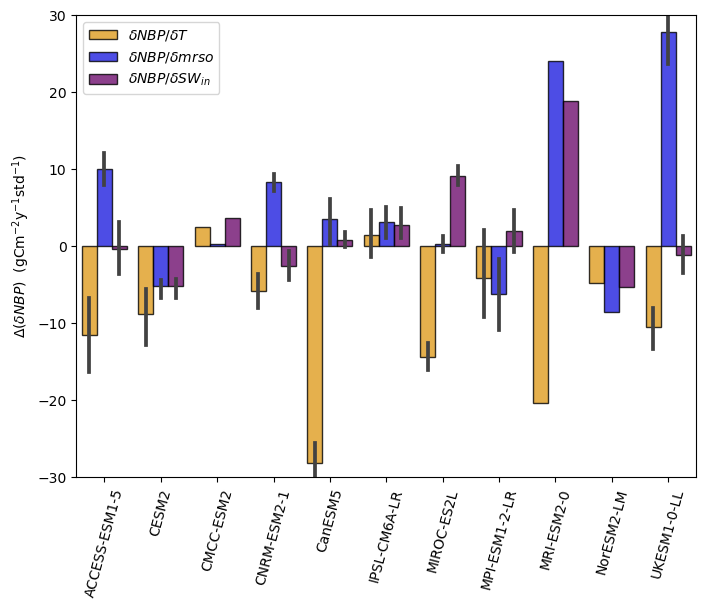

In [47]:
import seaborn as sns

fig = plt.figure(figsize=(8, 6))

data = df_delta[(df_delta['effect'] == 'nbp_tas') | (df_delta['effect'] == 'nbp_mrso') | 
                    (df_delta['effect'] == 'nbp_rsds')].copy() # | (df_delta['effect'] == 'nbp_vpd')].copy()

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(111)

ax0 = sns.barplot(
    data=data.rename(columns={'effect': 'variable'}), hue="variable",# errorbar=("pi", 50),
    x="esm", y="value",
    palette=["orange", "blue", "purple"], alpha=.8, edgecolor = "black"
)
ax0.set_ylim(-30, 30)
ax0.set_xticklabels(sorted(list(set(esm))), rotation = 75)
handles, _ = ax0.get_legend_handles_labels()
ax0.legend(handles, ["$\delta NBP/\delta T$", "$\delta NBP/\delta mrso$", "$\delta NBP/\delta SW_{in}$"], loc='upper left', fontsize = 10, )
ax0.set_xlabel("")
ax0.set_ylabel("$\Delta (\delta NBP)$  (gCm$^{-2}$y$^{-1}$std$^{-1}$)")

# g.despine(left=True)
title = 'Predictors coefficients in the Amazon Basin - Delta'
output_file = os.path.join(out_path, title) + "_f.png"


# g = sns.catplot(
#     data=df_delta[(df_delta['effect'] != 'nbp_pred') & (df_delta['effect'] != 'nbp')], kind="bar",# col = "scenario",
#     x="esm", y="value", hue="effect",
#     palette='colorblind', alpha=.6, height=6
# )

# # g.despine(left=True)
# title = 'Predictors coefficients in the Amazon Basin - Delta'
# g.fig.suptitle(title, y = 1.05)
# g.set_xticklabels(rotation = 75)
# g.set_axis_labels("", "nbp (gCm$^{-2}$y$^{-1}$)")
# g.fig.set_figwidth(10,8)
# output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')

PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_amz_ssp.drop(columns = ["esm"]))

pca_ssp_scores = pca.transform(df_amz_ssp.drop(columns = ["esm"]))
pca_ssp_loadings = pca.components_[:2].T

pca_ssp = pd.DataFrame(pca_ssp_scores).rename(columns = {0:"PC1", 1:"PC2"})
pca_ssp = pca_ssp.rename(index=dict(zip(pca_ssp.index, esm_list)))
pca_ssp = pd.concat([pca_ssp, df_amz_ssp.drop(columns = ["esm"])], axis = 1)

print("Variance explained is:", pca.explained_variance_ratio_)
print("PC coefficients are:", pca.components_)

Variance explained is: [0.43959352 0.32568193]
PC coefficients are: [[ 0.79743767 -0.55990468 -0.2155612   0.01969997 -0.06119792]
 [-0.35740498 -0.41660966 -0.23963579  0.76270301  0.2440428 ]]


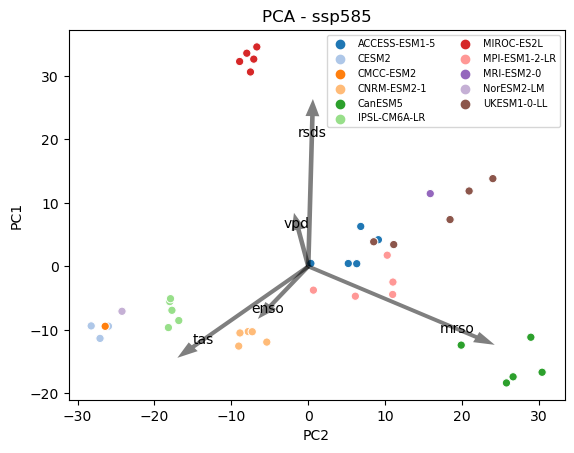

In [ ]:
arrows = pca_ssp_loadings * np.abs(pca_ssp_scores).max(axis=0)
features = df_amz_ssp.drop(columns = ["esm"]).columns.values


fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.scatterplot("PC1", "PC2", data=pca_ssp, hue=pca_ssp.index, palette = "tab20")

for i, arrow in enumerate(arrows):
    plt.arrow(0, 0, *arrow, color='k', alpha=0.5, width=0.6, ec='none',
              length_includes_head=True)
    plt.text(*(arrow * 0.8), features[i],
             ha='center', va='center')

ax.set(xlabel= "PC2", ylabel='PC1')
title= "PCA - ssp585"
ax.set_title(title)
# ax.set_xlim(-160, 150)
ax.legend(loc='upper right', ncol=2, fontsize = 7)
output_file = os.path.join(out_path, title) + "_f.png"
plt.savefig(output_file, bbox_inches='tight')


#### Scatterplot of Var values vs coefficients

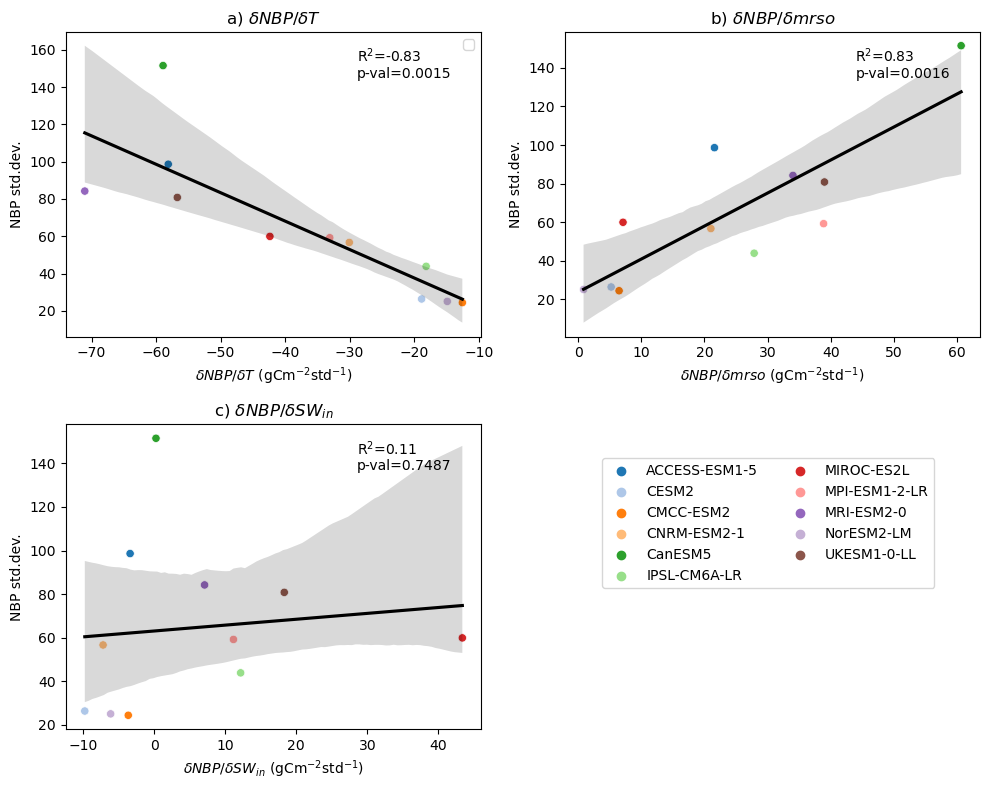

In [218]:
data = df_amz_ssp.groupby(df_amz_ssp.index).mean()

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, 0])
ax = sns.scatterplot("nbp_tas", 'nbp_std', data=data, hue=data.index, palette="tab20", legend = True)
ax = sns.regplot(x="nbp_tas", y='nbp_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="$\delta NBP/\delta T$ (gCm$^{-2}$std$^{-1}$)", ylabel='NBP std.dev.')
ax.legend(loc='upper left', ncol=2, fontsize = 8)
ax.text(.7, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['nbp_std'],data["nbp_tas"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.7, .85, 'p-val={:.4f}'.format(stats.linregress(data['nbp_std'],data["nbp_tas"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("a) $\delta NBP/\delta T$")
ax.legend("")

ax = fig.add_subplot(gs[0, 1])
ax = sns.scatterplot("nbp_mrso", 'nbp_std', data=data, hue=data.index, palette="tab20", legend = False)
ax = sns.regplot(x="nbp_mrso", y='nbp_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="$\delta NBP/\delta mrso$ (gCm$^{-2}$std$^{-1}$)", ylabel='NBP std.dev.')
ax.text(.7, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['nbp_std'],data["nbp_mrso"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.7, .85, 'p-val={:.4f}'.format(stats.linregress(data['nbp_std'],data["nbp_mrso"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("b) $\delta NBP/\delta mrso$")

ax = fig.add_subplot(gs[1, 0])
ax = sns.scatterplot("nbp_rsds", 'nbp_std', data=data, hue=data.index, palette="tab20", legend = False)
ax = sns.regplot(x="nbp_rsds", y='nbp_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="$\delta NBP/\delta SW_{in}$ (gCm$^{-2}$std$^{-1}$)", ylabel='NBP std.dev.')
ax.text(.7, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['nbp_std'],data["nbp_rsds"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.7, .85, 'p-val={:.4f}'.format(stats.linregress(data['nbp_std'],data["nbp_rsds"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("c) $\delta NBP/\delta SW_{in}$")
fig.legend(loc='lower left', bbox_to_anchor=(.6, .25), ncol=2, fontsize = 10)

fig.tight_layout()
title= "model diversity - ssporical, nbp_tas + nbp_mrso"
# output_file = os.path.join(out_path, title) + "_f_nbp_std.png"
# plt.savefig(output_file, bbox_inches='tight')

GPP

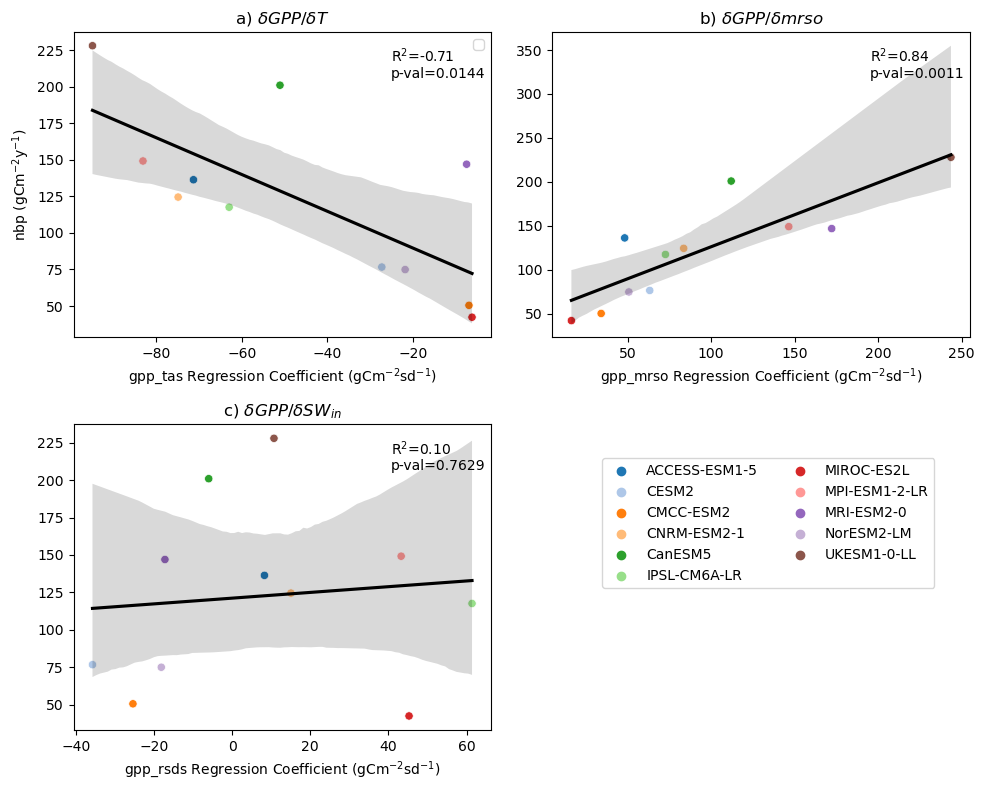

In [243]:
data = df_amz_ssp.groupby(df_amz_ssp.index).mean()

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, 0])
ax = sns.scatterplot("gpp_tas", 'gpp_std', data=data, hue=data.index, palette="tab20", legend = True)
ax = sns.regplot(x="gpp_tas", y='gpp_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="gpp_tas" + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel='nbp (gCm$^{-2}$y$^{-1}$)')
ax.legend(loc='upper left', ncol=2, fontsize = 8)
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['gpp_std'],data["gpp_tas"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['gpp_std'],data["gpp_tas"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("a) $\delta GPP/\delta T$")
ax.legend("")

ax = fig.add_subplot(gs[0, 1])
ax = sns.scatterplot("gpp_mrso", 'gpp_std', data=data, hue=data.index, palette="tab20", legend = False)
ax = sns.regplot(x="gpp_mrso", y='gpp_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="gpp_mrso" + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel=None)
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['gpp_std'],data["gpp_mrso"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['gpp_std'],data["gpp_mrso"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("b) $\delta GPP/\delta mrso$")

ax = fig.add_subplot(gs[1, 0])
ax = sns.scatterplot("gpp_rsds", 'gpp_std', data=data, hue=data.index, palette="tab20", legend = False)
ax = sns.regplot(x="gpp_rsds", y='gpp_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="gpp_rsds" + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel=None)
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['gpp_std'],data["gpp_rsds"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['gpp_std'],data["gpp_rsds"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("c) $\delta GPP/\delta SW_{in}$")
fig.legend(loc='lower left', bbox_to_anchor=(.6, .25), ncol=2, fontsize = 10)

fig.tight_layout()
title= "model diversity - ssporical, gpp_tas + gpp_mrso"
# output_file = os.path.join(out_path, title) + "_f_gpp_std.png"
# plt.savefig(output_file, bbox_inches='tight')

Rh

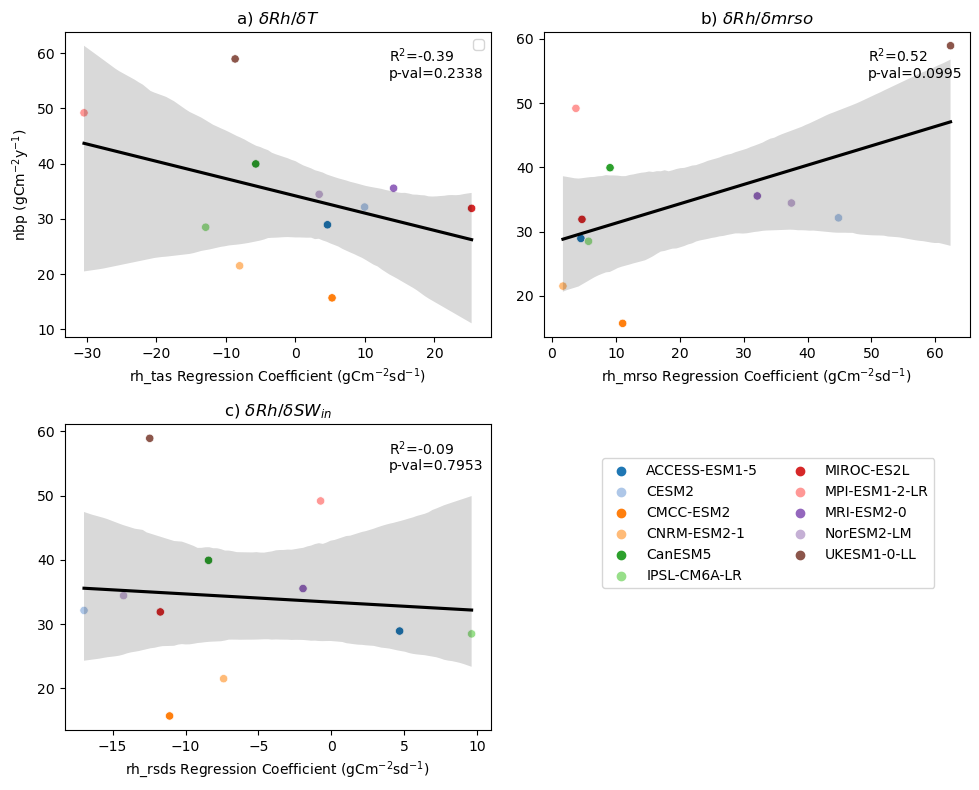

In [222]:
data = df_amz_ssp.groupby(df_amz_ssp.index).mean()

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, 0])
ax = sns.scatterplot("rh_tas", 'rh_std', data=data, hue=data.index, palette="tab20", legend = True)
ax = sns.regplot(x="rh_tas", y='rh_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="rh_tas" + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel='nbp (gCm$^{-2}$y$^{-1}$)')
ax.legend(loc='upper left', ncol=2, fontsize = 8)
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['rh_std'],data["rh_tas"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['rh_std'],data["rh_tas"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("a) $\delta Rh/\delta T$")
ax.legend("")

ax = fig.add_subplot(gs[0, 1])
ax = sns.scatterplot("rh_mrso", 'rh_std', data=data, hue=data.index, palette="tab20", legend = False)
ax = sns.regplot(x="rh_mrso", y='rh_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="rh_mrso" + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel=None)
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['rh_std'],data["rh_mrso"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['rh_std'],data["rh_mrso"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("b) $\delta Rh/\delta mrso$")

ax = fig.add_subplot(gs[1, 0])
ax = sns.scatterplot("rh_rsds", 'rh_std', data=data, hue=data.index, palette="tab20", legend = False)
ax = sns.regplot(x="rh_rsds", y='rh_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="rh_rsds" + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel=None)
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['rh_std'],data["rh_rsds"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['rh_std'],data["rh_rsds"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("c) $\delta Rh/\delta SW_{in}$")
fig.legend(loc='lower left', bbox_to_anchor=(.6, .25), ncol=2, fontsize = 10)

fig.tight_layout()
title= "model diversity - ssporical, rh_tas + rh_mrso"
# output_file = os.path.join(out_path, title) + "_f_rh_std.png"
# plt.savefig(output_file, bbox_inches='tight')

Ra

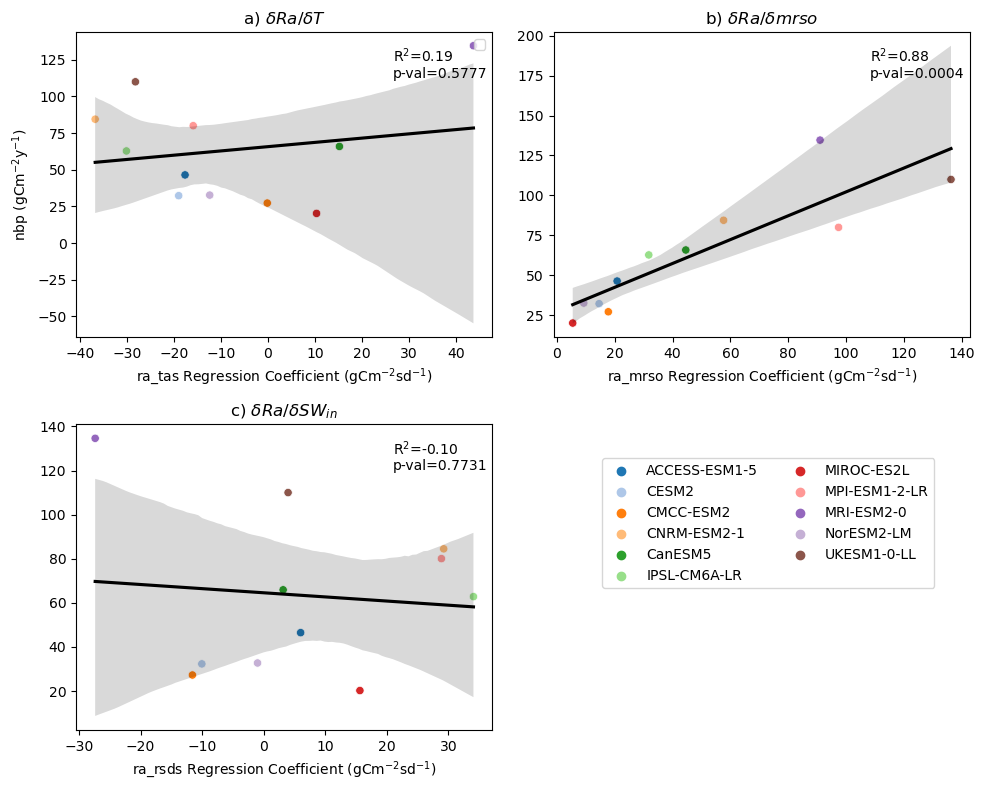

In [223]:
data = df_amz_ssp.groupby(df_amz_ssp.index).mean()

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, 0])
ax = sns.scatterplot("ra_tas", 'ra_std', data=data, hue=data.index, palette="tab20", legend = True)
ax = sns.regplot(x="ra_tas", y='ra_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="ra_tas" + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel='nbp (gCm$^{-2}$y$^{-1}$)')
ax.legend(loc='upper left', ncol=2, fontsize = 8)
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['ra_std'],data["ra_tas"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['ra_std'],data["ra_tas"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("a) $\delta Ra/\delta T$")
ax.legend("")

ax = fig.add_subplot(gs[0, 1])
ax = sns.scatterplot("ra_mrso", 'ra_std', data=data, hue=data.index, palette="tab20", legend = False)
ax = sns.regplot(x="ra_mrso", y='ra_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="ra_mrso" + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel=None)
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['ra_std'],data["ra_mrso"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['ra_std'],data["ra_mrso"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("b) $\delta Ra/\delta mrso$")

ax = fig.add_subplot(gs[1, 0])
ax = sns.scatterplot("ra_rsds", 'ra_std', data=data, hue=data.index, palette="tab20", legend = False)
ax = sns.regplot(x="ra_rsds", y='ra_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="ra_rsds" + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel=None)
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['ra_std'],data["ra_rsds"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['ra_std'],data["ra_rsds"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("c) $\delta Ra/\delta SW_{in}$")
fig.legend(loc='lower left', bbox_to_anchor=(.6, .25), ncol=2, fontsize = 10)

fig.tight_layout()
title= "model diversity - ssporical, ra_tas + ra_mrso"
# output_file = os.path.join(out_path, title) + "_f_ra_std.png"
# plt.savefig(output_file, bbox_inches='tight')

#### Intermodel differences

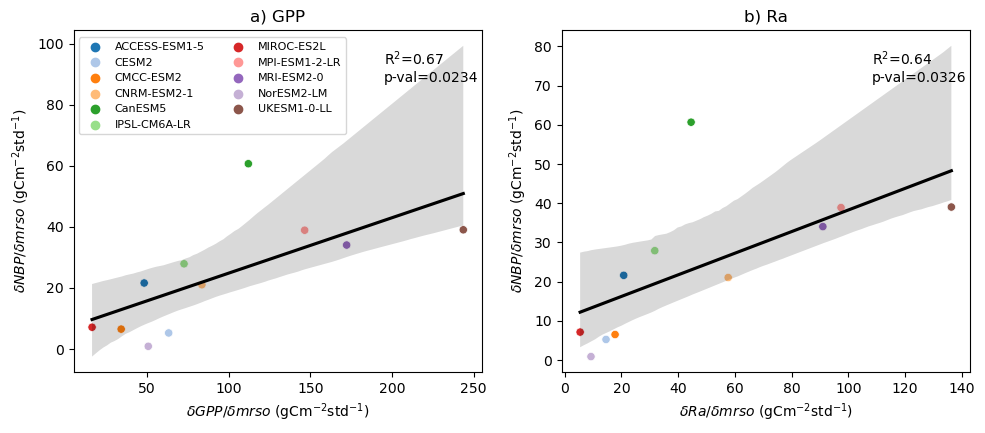

In [259]:
data = df_amz_ssp.groupby(df_amz_ssp.index).mean()

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, 0])
ax = sns.scatterplot("gpp_mrso", 'nbp_mrso', data=data, hue=data.index, palette="tab20", legend = True)
ax = sns.regplot(x="gpp_mrso", y='nbp_mrso', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="$\delta GPP/\delta mrso$ (gCm$^{-2}$std$^{-1}$)", ylabel="$\delta NBP/\delta mrso$ (gCm$^{-2}$std$^{-1}$)")
ax.legend(loc='upper left', ncol=2, fontsize = 8)
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['nbp_mrso'],data["gpp_mrso"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['nbp_mrso'],data["gpp_mrso"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("a) GPP")
ax.legend(loc='lower left', bbox_to_anchor=(0, .68), ncol=2, fontsize = 8)

ax = fig.add_subplot(gs[0, 1])
ax = sns.scatterplot("ra_mrso", 'nbp_mrso', data=data, hue=data.index, palette="tab20", legend = False)
ax = sns.regplot(x="ra_mrso", y='nbp_mrso', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="$\delta Ra/\delta mrso$ (gCm$^{-2}$std$^{-1}$)", ylabel="$\delta NBP/\delta mrso$ (gCm$^{-2}$std$^{-1}$)")
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['nbp_mrso'],data["ra_mrso"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['nbp_mrso'],data["ra_mrso"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("b) Ra")

fig.tight_layout()
title= "model diversity - ssporical, gpp_mrso + ra_mrso"
# output_file = os.path.join(out_path, title) + "_f_nbp_mrso.png"
# plt.savefig(output_file, bbox_inches='tight')

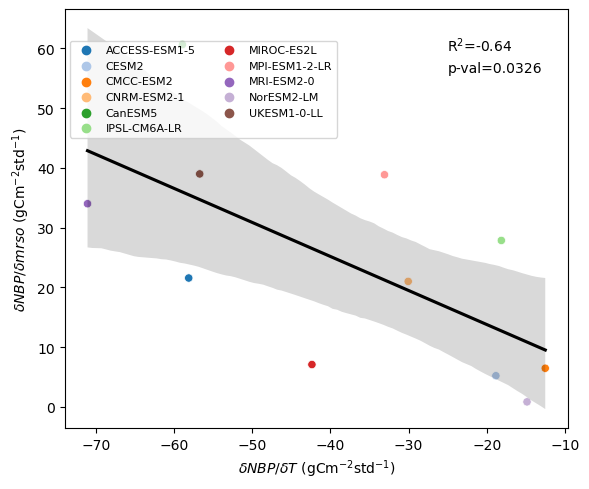

In [ ]:
data = df_amz_ssp.groupby(df_amz_ssp.index).mean()

fig = plt.figure(figsize=(6, 5))
gs = gridspec.GridSpec(1, 1)

ax = fig.add_subplot(gs[0, 0])
ax = sns.scatterplot("nbp_tas", 'nbp_mrso', data=data, hue=data.index, palette="tab20", legend = True)
ax = sns.regplot(x="nbp_tas", y='nbp_mrso', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="$\delta NBP/\delta T$ (gCm$^{-2}$std$^{-1}$)", ylabel="$\delta NBP/\delta mrso$ (gCm$^{-2}$std$^{-1}$)")
ax.legend(loc='upper left', ncol=2, fontsize = 8)
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['nbp_mrso'],data["nbp_tas"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['nbp_mrso'],data["nbp_tas"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
# ax.set_title("a) NBP")
ax.legend(loc='lower left', bbox_to_anchor=(0, .68), ncol=2, fontsize = 8)

# ax = fig.add_subplot(gs[0, 1])
# ax = sns.scatterplot("ra_tas", 'nbp_mrso', data=data, hue=data.index, palette="tab20", legend = False)
# ax = sns.regplot(x="ra_tas", y='nbp_mrso', data=data, scatter=False, line_kws={"color": "black"})
# ax.set(xlabel="$\delta Ra/\delta mrso$ (gCm$^{-2}$std$^{-1}$)", ylabel="$\delta NBP/\delta mrso$ (gCm$^{-2}$std$^{-1}$)")
# ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['nbp_mrso'],data["ra_tas"]).rvalue),
#             transform=ax.transAxes, fontsize = 10)
# ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['nbp_mrso'],data["ra_tas"]).pvalue),
#     transform=ax.transAxes, fontsize = 10)
# # ax.set_ylim(-200, 350)
# ax.set_title("b) Ra")

fig.tight_layout()
title= "model diversity - ssporical, nbp_tas + ra_tas"
# output_file = os.path.join(out_path, title) + "_f_nbp_mrso.png"
# plt.savefig(output_file, bbox_inches='tight')

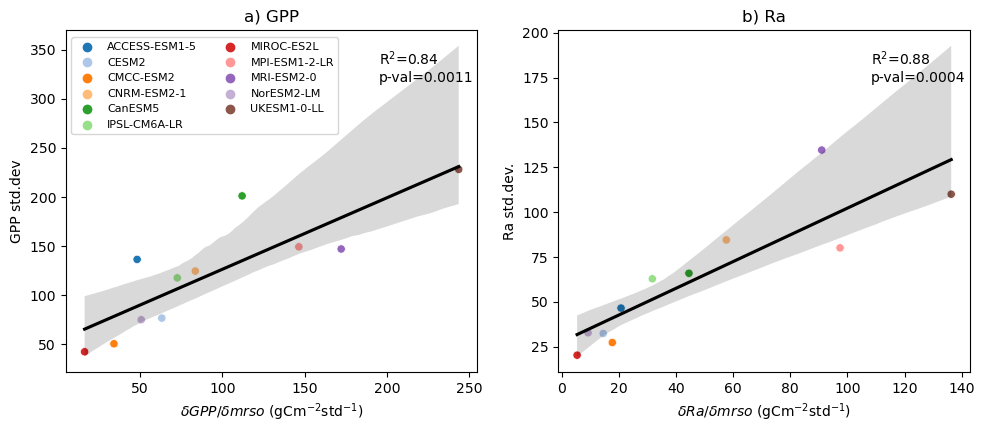

In [257]:
data = df_amz_ssp.groupby(df_amz_ssp.index).mean()

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, 0])
ax = sns.scatterplot("gpp_mrso", 'gpp_std', data=data, hue=data.index, palette="tab20", legend = True)
ax = sns.regplot(x="gpp_mrso", y='gpp_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="$\delta GPP/\delta mrso$ (gCm$^{-2}$std$^{-1}$)", ylabel="GPP std.dev")
ax.legend(loc='upper left', ncol=2, fontsize = 8)
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['gpp_std'],data["gpp_mrso"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['gpp_std'],data["gpp_mrso"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("a) GPP")
ax.legend(loc='lower left', bbox_to_anchor=(0, .68), ncol=2, fontsize = 8)

ax = fig.add_subplot(gs[0, 1])
ax = sns.scatterplot("ra_mrso", 'ra_std', data=data, hue=data.index, palette="tab20", legend = False)
ax = sns.regplot(x="ra_mrso", y='ra_std', data=data, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="$\delta Ra/\delta mrso$ (gCm$^{-2}$std$^{-1}$)", ylabel="Ra std.dev.")
ax.text(.76, .9, 'R$^2$={:.2f}'.format(stats.linregress(data['ra_std'],data["ra_mrso"]).rvalue),
            transform=ax.transAxes, fontsize = 10)
ax.text(.76, .85, 'p-val={:.4f}'.format(stats.linregress(data['ra_std'],data["ra_mrso"]).pvalue),
    transform=ax.transAxes, fontsize = 10)
# ax.set_ylim(-200, 350)
ax.set_title("b) Ra")

fig.tight_layout()
title= "model diversity - ssporical, gpp_mrso + ra_mrso"
# output_file = os.path.join(out_path, title) + "_f_gpp_std.png"
# plt.savefig(output_file, bbox_inches='tight')

### Plot coefficients and R2

In [281]:
coef_nbp_hist_esm = xr_mean_list(coef_nbp_hist)
coef_nbp_ssp_esm = xr_mean_list(coef_nbp_ssp)
fit_nbp_hist_esm = xr_mean_list(fit_nbp_hist)
fit_nbp_ssp_esm = xr_mean_list(fit_nbp_ssp)

Regrid to 1x1

In [282]:
import xesmf as xe

def lon180(ds):
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    return ds

coef_nbp_hist_esm = {k: lon180(coef_nbp_hist_esm[k]) for k in coef_nbp_hist_esm.keys()}
coef_nbp_ssp_esm = {k: lon180(coef_nbp_ssp_esm[k]) for k in coef_nbp_ssp_esm.keys()}
fit_nbp_hist_esm = {k: lon180(fit_nbp_hist_esm[k]) for k in fit_nbp_hist_esm.keys()}
fit_nbp_ssp_esm = {k: lon180(fit_nbp_ssp_esm[k]) for k in fit_nbp_ssp_esm.keys()}

ds_out = xe.util.cf_grid_2d(-100, -20, 1, -30, 30, 1)

regrid = [xe.Regridder(coef_nbp_hist_esm[k], ds_out, "bilinear") for k in coef_nbp_hist_esm.keys()]
# regrid = [xe.Regridder(a, ds_out, "bilineacoef_nbp_ssp_esm[k]") for k in coef_nbp_ssp_esm.keys()}

coef_nbp_hist_esm = {k: reg(coef_nbp_hist_esm[k], keep_attrs=True) for reg,k in zip(regrid,coef_nbp_hist_esm.keys())}
coef_nbp_ssp_esm = {k: reg(coef_nbp_ssp_esm[k], keep_attrs=True) for reg,k in zip(regrid,coef_nbp_ssp_esm.keys())}
fit_nbp_hist_esm = {k: reg(fit_nbp_hist_esm[k], keep_attrs=True) for reg,k in zip(regrid,fit_nbp_hist_esm.keys())}
fit_nbp_ssp_esm = {k: reg(fit_nbp_ssp_esm[k], keep_attrs=True) for reg,k in zip(regrid,fit_nbp_ssp_esm.keys())}

In [291]:
# Separate predictors HIST
coef_nbp_hist_esm_tas = xr.concat([coef_nbp_hist_esm[k].sel(coefficients = 0).rename("tas") for k in coef_nbp_hist_esm.keys()],dim = "esm")
coef_nbp_hist_esm_mrso = xr.concat([coef_nbp_hist_esm[k].sel(coefficients = 1).rename("mrso") for k in coef_nbp_hist_esm.keys()],dim = "esm")
coef_nbp_hist_esm_rsds = xr.concat([coef_nbp_hist_esm[k].sel(coefficients = 2).rename("rsds") for k in coef_nbp_hist_esm.keys()],dim = "esm")

# Separate predictors SSP
coef_nbp_ssp_esm_tas = xr.concat([coef_nbp_ssp_esm[k].sel(coefficients = 0).rename("tas") for k in coef_nbp_ssp_esm.keys()],dim = "esm")
coef_nbp_ssp_esm_mrso = xr.concat([coef_nbp_ssp_esm[k].sel(coefficients = 1).rename("mrso") for k in coef_nbp_ssp_esm.keys()],dim = "esm")
coef_nbp_ssp_esm_rsds = xr.concat([coef_nbp_ssp_esm[k].sel(coefficients = 2).rename("rsds") for k in coef_nbp_ssp_esm.keys()],dim = "esm")

In [ ]:
# Multimodel mean
coef_nbp_hist_esm_tas_mean = coef_nbp_hist_esm_tas.mean(dim = "esm")
coef_nbp_hist_esm_mrso_mean = coef_nbp_hist_esm_mrso.mean(dim = "esm")
coef_nbp_hist_esm_rsds_mean = coef_nbp_hist_esm_rsds.mean(dim = "esm")

coef_nbp_ssp_esm_tas_mean = coef_nbp_ssp_esm_tas.mean(dim = "esm")
coef_nbp_ssp_esm_mrso_mean = coef_nbp_ssp_esm_mrso.mean(dim = "esm")
coef_nbp_ssp_esm_rsds_mean = coef_nbp_ssp_esm_rsds.mean(dim = "esm")


In [296]:
# Multimodel agreement
# Put 1 when value is positive and -1 when negative
# Sum the values of the esm list within every cell
# Take the absolute value: This will give the net number of models that agree on the sign of the coefficient 
# Take the absolute value of the sum: if 8 out of 11 (value is +5) esm agree (+5/+11 = 0.4545), then hatch

mm_sign_tas = xr.where(coef_nbp_hist_esm_tas>0, 1, -1)
mm_sign_mrso = xr.where(coef_nbp_hist_esm_mrso>0, 1, -1)
mm_sign_rsds = xr.where(coef_nbp_hist_esm_rsds>0, 1, -1)

mm_sign_tas_hist = np.ma.masked_less((np.abs(mm_sign_tas.sum(dim = "esm")/11)), 0.4545)
mm_sign_mrso_hist = np.ma.masked_less((np.abs(mm_sign_mrso.sum(dim = "esm")/11)), 0.4545)
mm_sign_rsds_hist = np.ma.masked_less((np.abs(mm_sign_rsds.sum(dim = "esm")/11)), 0.4545)

mm_sign_tas = xr.where(coef_nbp_ssp_esm_tas>0, 1, -1)
mm_sign_mrso = xr.where(coef_nbp_ssp_esm_mrso>0, 1, -1)
mm_sign_rsds = xr.where(coef_nbp_ssp_esm_rsds>0, 1, -1)

mm_sign_tas_ssp = np.ma.masked_less((np.abs(mm_sign_tas.sum(dim = "esm")/11)), 0.4545)
mm_sign_mrso_ssp = np.ma.masked_less((np.abs(mm_sign_mrso.sum(dim = "esm")/11)), 0.4545)
mm_sign_rsds_ssp = np.ma.masked_less((np.abs(mm_sign_rsds.sum(dim = "esm")/11)), 0.4545)


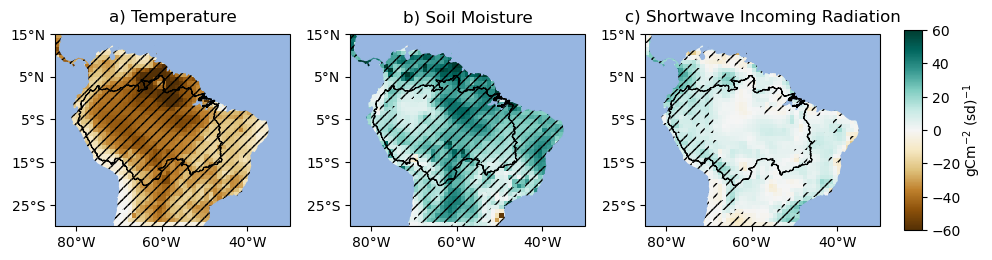

In [306]:
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

scenario = "ssp585"

if scenario == "historical":
    mean_plot = [coef_nbp_hist_esm_tas_mean,coef_nbp_hist_esm_mrso_mean,coef_nbp_hist_esm_rsds_mean]
    hatch_plot = [mm_sign_tas_hist,mm_sign_mrso_hist,mm_sign_rsds_hist]

if scenario == "ssp585":
    mean_plot = [coef_nbp_ssp_esm_tas_mean,coef_nbp_ssp_esm_mrso_mean,coef_nbp_ssp_esm_rsds_mean]
    hatch_plot = [mm_sign_tas_ssp,mm_sign_mrso_ssp,mm_sign_rsds_ssp]

if scenario == "delta":
    mean_plot = [   coef_nbp_ssp_esm_tas_mean - coef_nbp_hist_esm_tas_mean,
                    coef_nbp_ssp_esm_mrso_mean - coef_nbp_hist_esm_mrso_mean,
                    coef_nbp_ssp_esm_rsds_mean -coef_nbp_hist_esm_rsds_mean]

letter = ["a) Temperature", "b) Soil Moisture", "c) Shortwave Incoming Radiation"]
reader = shpreader.Reader('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')
amz = [region for region in reader.records() if region.attributes['PFAF_ID'] == 62][0]
amz = ShapelyFeature([amz.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.8)

# Create the figure 
fig = plt.figure(figsize=(9, 5)) #, constrained_layout=True)
gs = gridspec.GridSpec(1, 3)

for i, ax in enumerate(mean_plot):

    ax = fig.add_subplot(gs[0, i], projection = ccrs.PlateCarree())

    lats = mean_plot[i].lat; lons = mean_plot[i].lon
    map1 = mean_plot[i].plot.pcolormesh(vmin=-60, vmax=60, cmap="BrBG", transform = ccrs.PlateCarree(), add_colorbar = False, add_labels = False)
    if scenario == "historical" or scenario == "ssp585":
        map = ax.pcolor(lons, lats, hatch_plot[i], hatch = '///', transform = ccrs.PlateCarree(), alpha = 0)
    else:
        None
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.add_feature(amz)
    ax.set_extent([-85, -30, -30, 15], ccrs.PlateCarree())
    # Longitude labels
    ax.set_xticks(np.arange(-80,-30,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    # Latitude labels
    ax.set_yticks(np.arange(-25,20,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(letter[i], y = 1.02)

fig.subplots_adjust(bottom=0.0, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.0)
fig.tight_layout()
cbar_ax = fig.add_axes([1.01, 0.3, 0.02, 0.4]) # Left, Bottom, Width, Height
clb = fig.colorbar(map1, cax=cbar_ax)
clb.set_label("gCm$^{-2}$ (sd)$^{-1}$",fontsize= 10,labelpad = 0.2)
title = "MM Ridge Regression coefficients agreement - " + scenario
# fig.suptitle(title, x = 0.45, y = 1, fontsize = 14)

# Output file
output_file = os.path.join(out_path, title) + "_f_10outof13.png"
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

In [78]:
pval_ridge_hist_fdr = []
pval_ridge_ssp_fdr = []
for i, item in enumerate(pval_ridge_hist):
    reject, xpvals_corrected_hist = xr_multipletest(pval_ridge_hist[i])
    reject, xpvals_corrected_ssp = xr_multipletest(pval_ridge_ssp[i])
    pval_ridge_hist_fdr.append(xpvals_corrected_hist)
    pval_ridge_ssp_fdr.append(xpvals_corrected_ssp)

In [79]:
# Delta_nbp sensitivity to pr and tas
delta_coef_ridge = [] 
for i in np.arange(13): #enumerate(esm):
    content = (coef_ridge_ssp[i] - coef_ridge_hist[i])
    delta_coef_ridge.append(content)

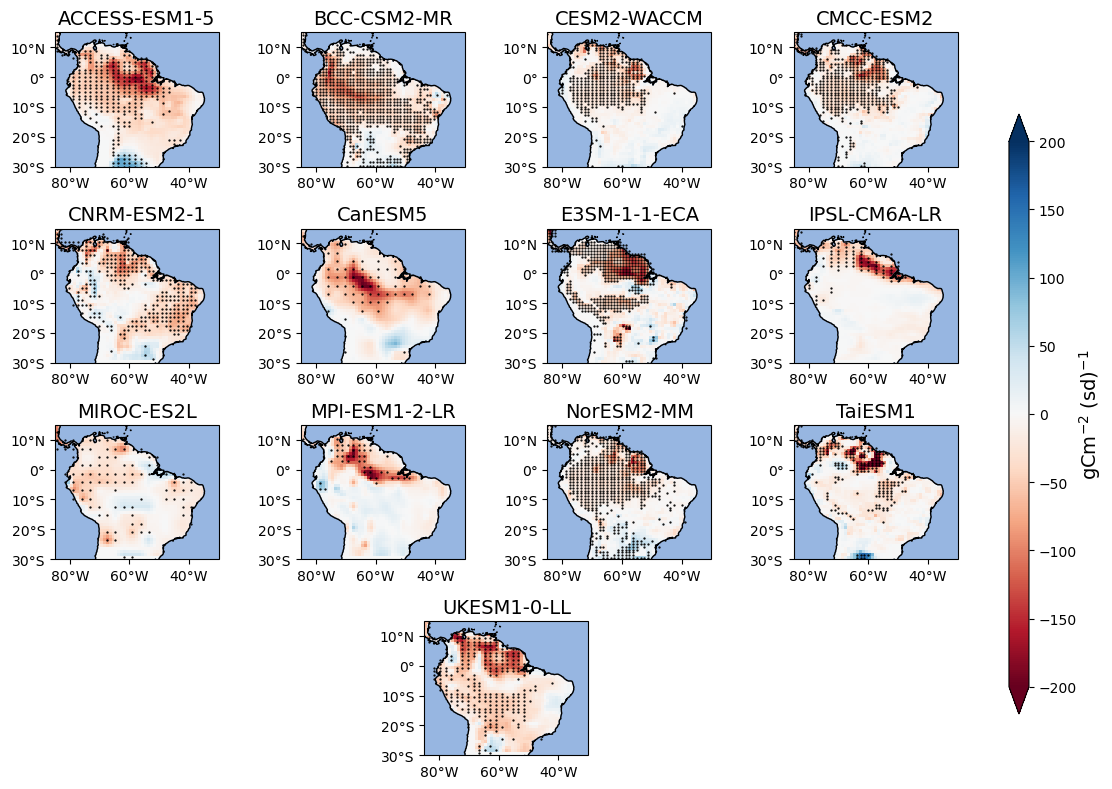

In [133]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

seas = "DJF"

# --- Define data to plot
to_plot = "coef_hist"; predictor = "enso"

if to_plot == "coef_hist":
    data_plot = coef_ridge_hist.copy()
    hatch_plot = pval_ridge_hist_fdr.copy()
    cbar_label = 'gCm$^{-2}$ (sd)$^{-1}$'
    cmap = "RdBu"
    title = '\u03B3nbp_enso historical - Ridge Regression - ENSO -'  + seas + '_1901-1960'

if to_plot == "coef_ssp":
    data_plot = coef_ridge_ssp.copy()
    hatch_plot = pval_ridge_ssp_fdr.copy()
    cbar_label = 'gCm$^{-2}$ (sd)$^{-1}$'
    cmap = "RdBu"
    title = '\u03B3nbp_enso ssp585 - Ridge Regression - ENSO -'  + seas + '_2041-2100'

if to_plot == "delta":
    data_plot = delta_coef_ridge.copy()
    cbar_label = 'gCm$^{-2}$ (sd)$^{-1}$'
    cmap = "BrBG"
    title = '\u0394\u03B3nbp_enso ssp585 - Ridge Regression - ENSO -'  + seas

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 8

# --- Colorbar configuration#
min_value, max_value = None, None                                       #automatic colorbar limits
cbar_position = "top"
cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 0
}

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if predictor == "pr":
        data_plot[i] = data_plot[i].sel(coefficients = 0); hatch_plot[i] = hatch_plot[i].sel(pvalues = 0)
    if predictor == "tas":
        data_plot[i] = data_plot[i].sel(coefficients = 1); hatch_plot[i] = hatch_plot[i].sel(pvalues = 1)
    if predictor == "enso":
        data_plot[i] = data_plot[i].sel(coefficients = 2); hatch_plot[i] = hatch_plot[i].sel(pvalues = 2)
    if predictor == "rsds":
        data_plot[i] = data_plot[i].sel(coefficients = 3); hatch_plot[i] = hatch_plot[i].sel(pvalues = 3)
    if predictor == "vpd":
        data_plot[i] = data_plot[i].sel(coefficients = 4); hatch_plot[i] = hatch_plot[i].sel(pvalues = 4)

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

    lons = hatch_plot[i].lon
    lats = hatch_plot[i].lat
    pearson_r_single_95x =[]
    pearson_r_single_95y =[] 
    for y,itemy in enumerate(lats):
        for x,itemx in enumerate(lons):
            if hatch_plot[i][x][y]<0.05:                   # Define the significance level of Mann Whitney test                       
                contentx =itemx                                          # If < sign significant gridcells, if > sign not-significant gridcells
                contenty =itemy
                pearson_r_single_95x.append(contentx)
                pearson_r_single_95y.append(contenty)

    # map1 = ax.pcolormesh(lons, lats, data_plot[i].sel(coefficients = 0), vmin=min_value, vmax=max_value, transform = ccrs.PlateCarree(), cmap=cmap) 
    map1 = data_plot[i].plot.pcolormesh(ax = ax, x = "lon", y = "lat", vmin=-200, vmax=200, cmap=cmap, transform = ccrs.PlateCarree(), add_colorbar = False, add_labels = False)
    sign = np.ma.masked_greater(hatch_plot[i], 0.05)

    # map = ax.pcolor(lats, lons, sign, hatch = '///', transform = ccrs.PlateCarree(), alpha = 0.5)
    ax.plot(pearson_r_single_95x, pearson_r_single_95y, "o", transform = ccrs.PlateCarree(), markersize = 0.6, color="black")

    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.coastlines()
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  

    ## XtickLabels alternative 1
    # Longitude labels
    ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    #ax.set_xlabel(xlabel, **xlabel_fontstyle)
    # Latitude labels
    ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  


# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.75])                     # Left, Bottom, Width, Height
clb = fig.colorbar(map1, cax=cbar_ax, extend="both")
clb.set_label(cbar_label, **cbar_fontstyle)
# clb.ax.set_yticklabels(np.arange(-6,9,2))

# --- Output file
output_file = os.path.join(out_path, title) + "_c.png"
# plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()

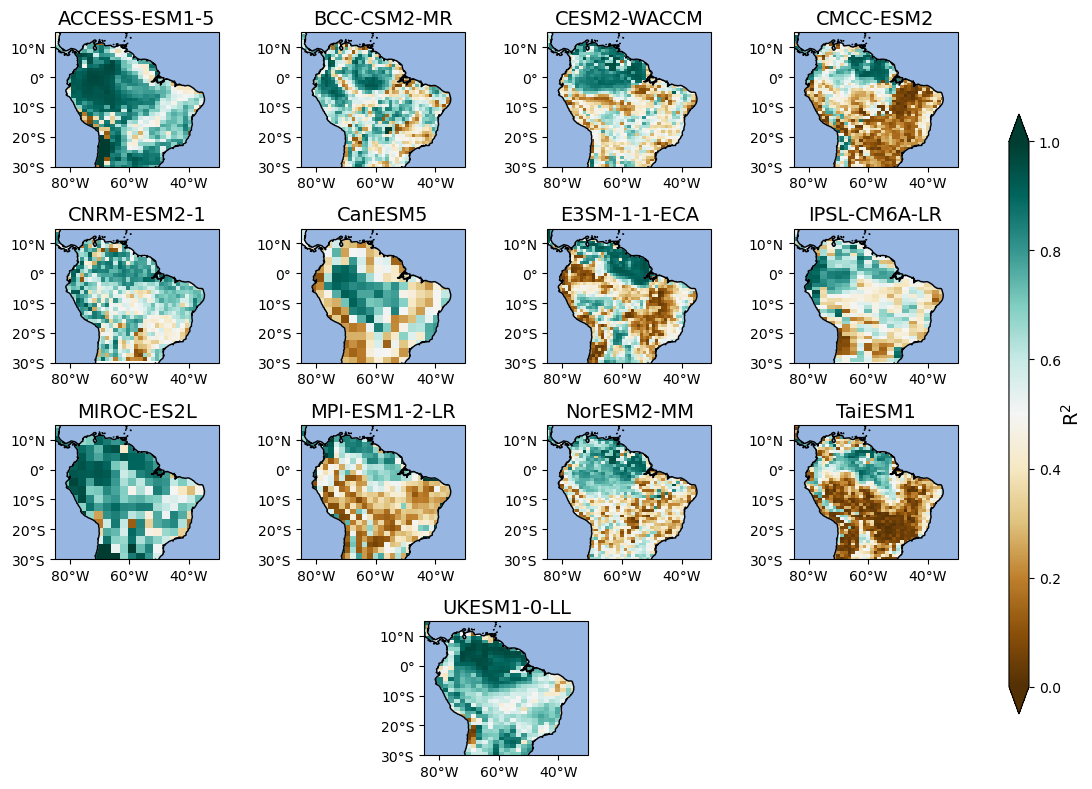

In [84]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# --- Define data to plot
to_plot = "r2_ssp"

if to_plot == "r2_hist":
    data_plot = r2_ridge_hist.copy()
    cbar_label = 'R$^{2}$'
    cmap = "BrBG"
    title = 'R2 historical - Ridge Regression - ENSO -'  + seas + '_1901-1960'

if to_plot == "r2_ssp":
    data_plot = r2_ridge_ssp.copy()
    cbar_label = 'R$^{2}$'
    cmap = "BrBG"
    title = 'R2 ssp585 - Ridge Regression - ENSO -'  + seas + '_2041-2100'

if to_plot == "pred_hist":
    data_plot = pred_ridge_hist
    cbar_label = ''
    cmap = "RdYlGn"
    title = 'Pred_nbp historical - Ridge Regression - ENSO -'  + seas

if to_plot == "pred_ssp":
    data_plot = pred_ridge_ssp
    cbar_label = ''
    cmap = "RdYlGn"
    title = 'Pred_nbp ssp585 - Ridge Regression - ENSO -'  + seas

# --- Set the area: choose the min and max values for the coordinates                                                                                                                          
# Set lat-lon limits - CUSTOM
lon_min = -85
lon_max = -30
lat_min = -30 
lat_max = 15

# --- Plot configuration
width_inch = 10
height_inch = 8

# --- Colorbar configuration#
min_value, max_value = None, None                                       #automatic colorbar limits
cbar_position = "top"
cbar_fontstyle = {
    "fontsize": "14",
    "labelpad": 0
}

xlabel = 'longitude [deg]'
ylabel = 'latitude [deg]'

# Create the figure 
fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(4, 8)

# Iteratively create subplots 
for i, ax in enumerate(data_plot):

    if i < 4:
        ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
    if ((i > 3) and (i < 8)):
        ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
    if ((i > 7) and (i < 12)):
        ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
    if i > 11:
        ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

    # lons = data_plot[i].lon
    # lats = data_plot[i].lat
    # map1 = ax.pcolormesh(lons, lats, data_plot[i], vmin=0, vmax=1, transform = ccrs.PlateCarree(), cmap=cmap) 
    map1 = data_plot[i].astype(np.float64).plot.pcolormesh(ax = ax, x = "lon", y = "lat", vmin=0, vmax=1, cmap=cmap, transform = ccrs.PlateCarree(), add_colorbar = False, add_labels = False)

    ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
    ax.coastlines()
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  

    ## XtickLabels alternative 1
    # Longitude labels
    ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
    lon_formatter = LONGITUDE_FORMATTER
    ax.xaxis.set_major_formatter(lon_formatter)
    #ax.set_xlabel(xlabel, **xlabel_fontstyle)
    # Latitude labels
    ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
    lat_formatter = LATITUDE_FORMATTER
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(data_plot[i]["esm"].values,fontsize=14)  


# --- Plot colorbar
#fig.subplots_adjust(wspace=0, hspace=0)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
fig.tight_layout()
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.75])                     # Left, Bottom, Width, Height
clb = fig.colorbar(map1, cax=cbar_ax, extend="both")
clb.set_label(cbar_label, **cbar_fontstyle)
# clb.ax.set_yticklabels(np.arange(-6,9,2))

# --- Output file
output_file = os.path.join(out_path, title) + "_c.png"
plt.savefig(output_file, bbox_inches='tight')
plt.show()
plt.close()